# 1 Regression Methods
## 1.1 Processing stock price data in Python
### (1) Log plot of the price data

In [511]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

px = pd.read_csv('priceData.csv', header=0, index_col=0)

In [512]:
logpx = np.log(px)

<AxesSubplot:title={'center':'Log SPX Trend'}, xlabel='date'>

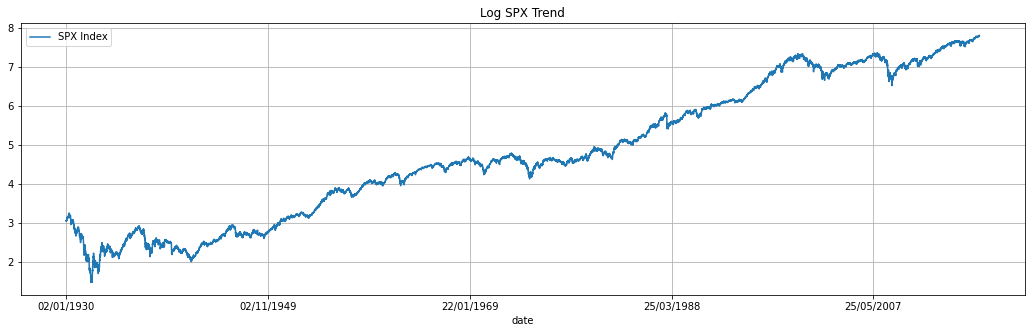

In [513]:
logpx.plot(grid=True, title='Log SPX Trend', figsize=(18,5))

As there are some missing data in the csv file, dropna is first used to remove those blanks. The Log diagram without the missing data price then is drawn:

<AxesSubplot:title={'center':'Adjusted Log SPX Trend'}, xlabel='date'>

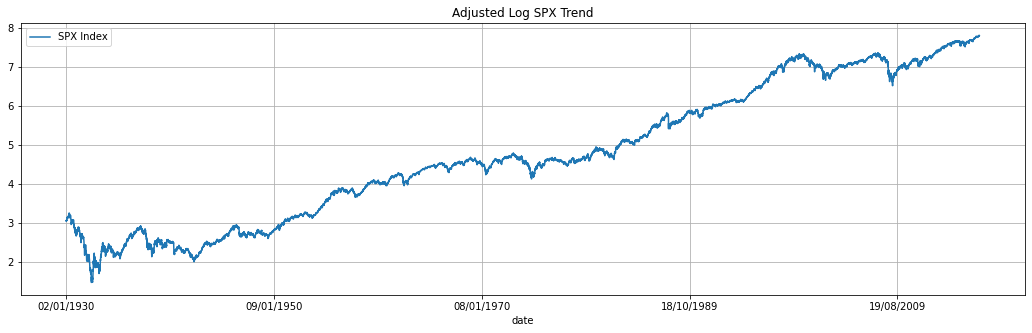

In [514]:
lognew = logpx.dropna()
lognew.plot(grid=True, title='Adjusted Log SPX Trend', figsize=(18,5))

### (2) Stationary of price time-series

<AxesSubplot:title={'center':'Log-price Sliding Variance'}, xlabel='date'>

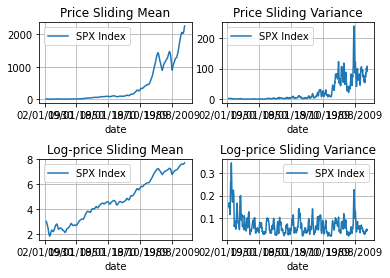

In [515]:
# Drop the dates with missing price values
pxnew = px.dropna()
lognew = logpx.dropna()

fig, axes = plt.subplots(2,2)
fig.subplots_adjust(hspace=0.7)

# Slinding window has the size of 252 days
pricemean = pxnew.rolling(252).mean()
pricemean.plot(ax=axes[0,0], grid=True, title='Price Sliding Mean')
pricevar = pxnew.rolling(252).std()
pricevar.plot(ax=axes[0,1], grid=True, title='Price Sliding Variance')

logmean = lognew.rolling(252).mean()
logmean.plot(ax=axes[1,0], grid=True, title='Log-price Sliding Mean')
logvar = lognew.rolling(252).std()
logvar.plot(ax=axes[1,1], grid=True, title='Log-price Sliding Variance')

If a stochastic signal is considered to be stationary, its mean and variance should not change over time. $X(t)$ and $X(t+\Delta)$ should have the same distribution. From the graphs above, all signals are quite fluctuated during the time. <br/>
Therefore, the price time-series is not stationary.

### (3) Time-series returns
Looking at returns may give a better view of the stock data. The return can also be calculated in two ways, nominal simple return and the log return.<br/>
For simple return: 
$$
R[t] = \frac{p[t]-p[t-1]}{p[t-1]} = \frac{p[t]}{p[t-1]}-1
$$
The log return:
$$
r[t] = log[\frac{p[t]}{p[t-1]}] = log[p(t)] - log[p(t-1)]
$$

<AxesSubplot:title={'center':'Log-return Variance'}, xlabel='date'>

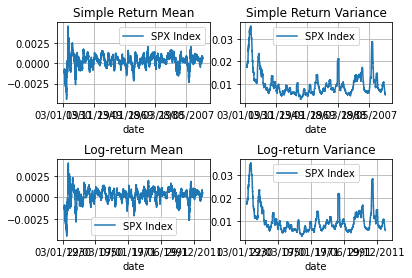

In [518]:
# Log return
logg = logpx.diff()
logret = logg.dropna()

# Simple return
simpp = px.pct_change()
simpret = simpp.dropna()

fig, axes = plt.subplots(2,2)
fig.subplots_adjust(hspace=0.7)

simpmean = simpret.rolling(252).mean()
simpmean.plot(ax=axes[0,0], grid=True, title='Simple Return Mean')
simpvar = simpret.rolling(252).std()
simpvar.plot(ax=axes[0,1], grid=True, title='Simple Return Variance')

logmean = logret.rolling(252).mean()
logmean.plot(ax=axes[1,0], grid=True, title='Log-return Mean')
logvar = logret.rolling(252).std()
logvar.plot(ax=axes[1,1], grid=True, title='Log-return Variance')

From the resulting figures, the mean of both returns behave in a back-and-forth oscillation within a very small range (around 0.005) and the variances also vary within a narrow range from 0 to 0.03. <br/>
This shows that both the simple return and the log-return are quite stationary.

### (4) Jarque-Bera test for Gaussianity on time-series returns

In [ ]:
from scipy import stats

# Test for simple return 

simplejb = stats.jarque_bera(simpret)
print('Jarque-Bera test for simple return: ', simplejb)

In [ ]:
logjb = stats.jarque_bera(logpx.diff().dropna())
print('Jarque-Bera test for log return: ', logjb)

### (5) Simple & Log return of the stock
According to the equations above, simple return $R[t] = \frac{p[t]}{p[t-1]} - 1$ and the log return $r[t] = log[p(t)] - log[p(t-1)]$. The log funciton is a **log-2** based function when using Python.

In [ ]:
ret = pd.Series([1, 2, 1])
simppret = ret.pct_change()[1:].values
loggret = ret.diff()[1:].values
print('Simple return will be: \n', simppret)
print('Log return will be: \n', loggret)

### (6) Simple return vs Log return
Sometimes simple return is preferred rathere than applying log return. <br/>
1) Log return is not suitable for a lonng term time-scale. Log-normality assumption is unrealistic for a long period of data. As log return assumes a distribution with a positive skew, but for long-term data, it would usually have a negative skewness instead. <br/><br/>
2) Non-linearity of log return. Due to its non-linearity compared to a simple return, the accumulation of returns will also be non-linear.

## 1.2 ARMA vs. ARIMA Models for Financial Applications
### (1) S&P500 with ARMA & ARIMA model

In [519]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
import copy

# Import data
snp = pd.read_csv('snp_500_2015_2019.csv')

In [520]:
snp.set_index(['Date'], inplace=True)
snp_close = snp['Close'].to_frame().apply(np.log)

<AxesSubplot:title={'center':'S&P500 time series'}, xlabel='Date'>

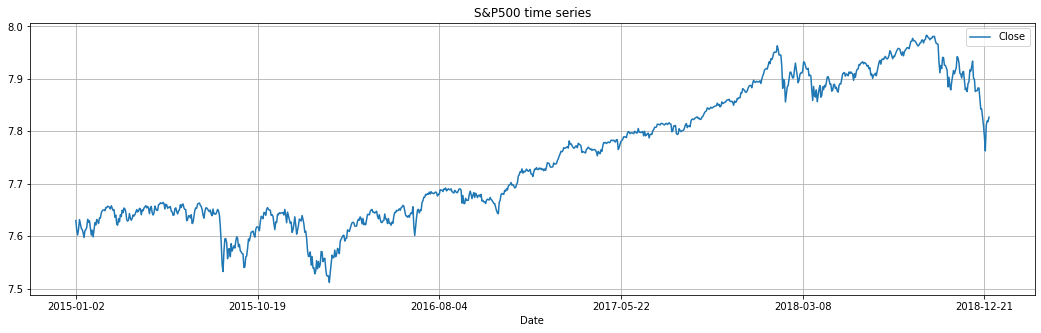

In [521]:
snp_close.plot(grid=True, title='S&P500 time series', figsize=(18,5))

A stochastic ARMA (autoregressive-moving-average) process with order p would have the following:
$$ x[t] = a_{1}x[t-1] + ... a_{p}x[t-p] + \eta [t] = \sum_{i=1}^{p} a_{i}x[t-i] + \sum_{i=1}^{q} b_{i}\eta[t-i] + \eta [t] $$
It regresses the variable on its past values with a additional linear combination of noise happened in the past. <br/>
The autocorrelation coefficient is obtained by the Yule-Walker equations in compact vector-matrix form, $a = R_{xx}^{-1} r_{xx}$. 

However, the ARMA progress should be used when data is stationary. Otherwise, the generalization of ARMA, the ARIMA (autoregressive integrated moving average) model will be used instead. <br/>
To check whether an ARMA or an ARIMA model is more suitable for S&P500 index, we check how stationary the S&P500 is.

<AxesSubplot:title={'center':'S&P500 Sliding Variance'}, xlabel='Date'>

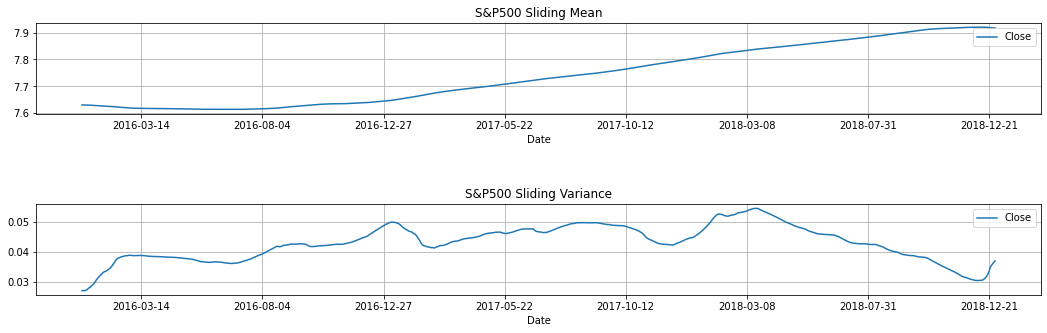

In [594]:
fig, axes = plt.subplots(2,1)
fig.subplots_adjust(hspace=1)

snpmean = snp_close.rolling(252).mean()
snpmean.plot(ax=axes[0], grid=True, title='S&P500 Sliding Mean', figsize=(18,5))

snpvar = snp_close.rolling(252).std()
snpvar.plot(ax=axes[1], grid=True, title='S&P500 Sliding Variance', figsize=(18,5))

As the plots shown above, S&P500 index is quite unstable and therefore ARIMA will be theoretically preferred.<br/>
### (2) ARMA model

In [595]:
import warnings
warnings.filterwarnings('ignore')

snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ['True']

snp_arma['Res'] = ARIMA(snp_arma['True'].values, order=(1,0,0)).fit().resid
snp_arma['Prediction'] = snp_arma['True'] - snp_arma['Res']

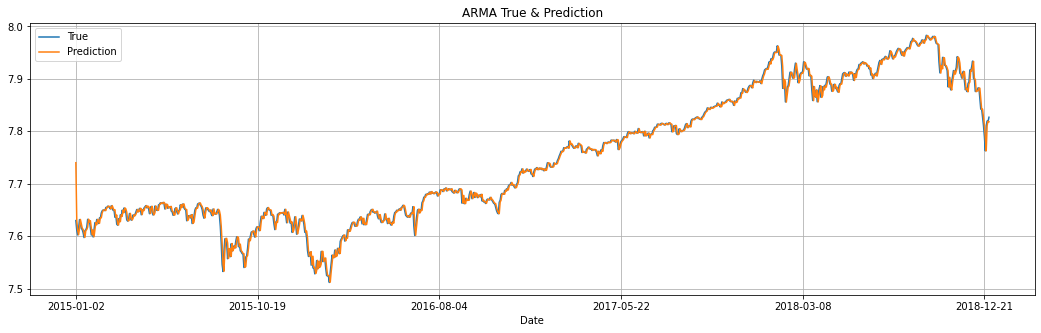

In [596]:
fig, axes = plt.subplots()

# True and Prediction signal plots
snp_arma['True'].plot(grid=True, label='True', title = 'ARMA True & Prediction', figsize=(18,3))
snp_arma['Prediction'].plot(grid=True, label='Prediction', figsize=(18,5))
legend = plt.legend(['True', 'Prediction'])

<AxesSubplot:title={'center':'ARMA Residual'}, xlabel='Date'>

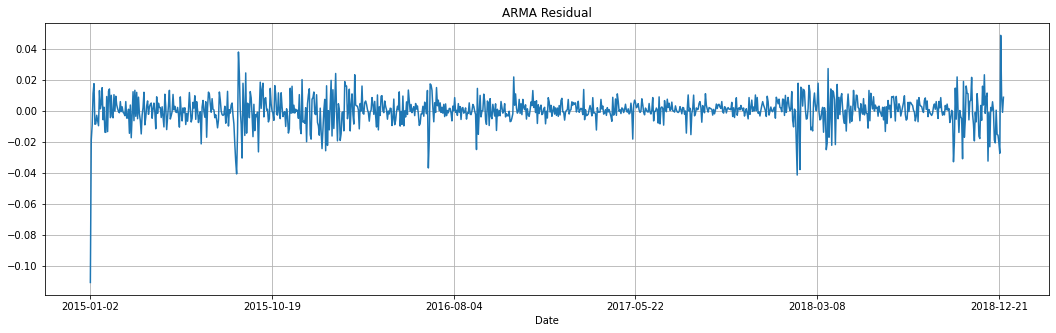

In [597]:
# Plot of Residue
snp_arma['Res'].plot(grid=True, label='Residual', title = 'ARMA Residual', figsize=(18,5))

In [598]:
arma_para = ARIMA(snp_arma['True'].values, order=(1,0,0)).fit().arparams
print('The model parameter of ARMA is: ', arma_para)

The model parameter of ARMA is:  [0.99735936]


### (3) ARIMA model

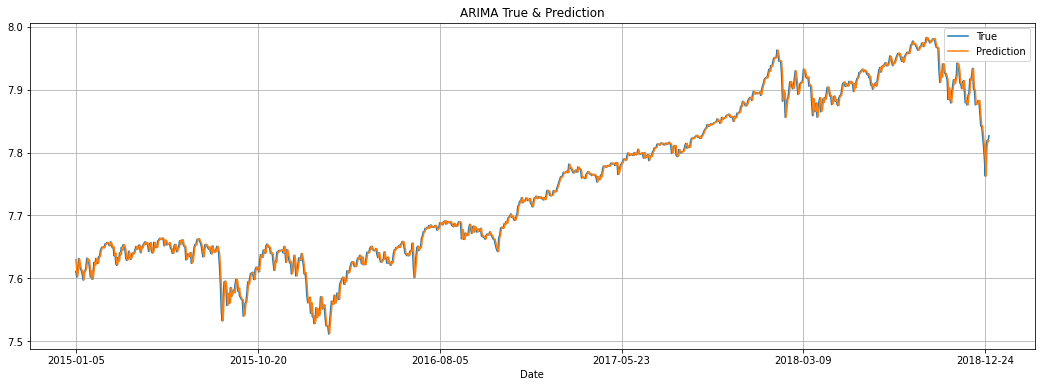

In [599]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ['True']

# The size of true value should match with the residual(size of 1005), therefore start from the second value of "arima_true"
arima_res = ARIMA(snp_arma['True'].values, order=(1,1,0)).fit().resid
arima_true = snp_arma['True'][1:]
arima_pre = arima_true - arima_res


fig, axes = plt.subplots()

# True and Prediction signal plots
arima_true.plot(grid=True, label='True', title = 'ARIMA True & Prediction', figsize=(18,5))
arima_pre.plot(grid=True, label='Prediction', figsize=(18,6))
legend = plt.legend(['True', 'Prediction'])

In [600]:
snp_arma.index

Index(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
       '2015-01-09', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15',
       ...
       '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21',
       '2018-12-24', '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-31'],
      dtype='object', name='Date', length=1006)

<AxesSubplot:title={'center':'ARIMA Residual'}, xlabel='Date'>

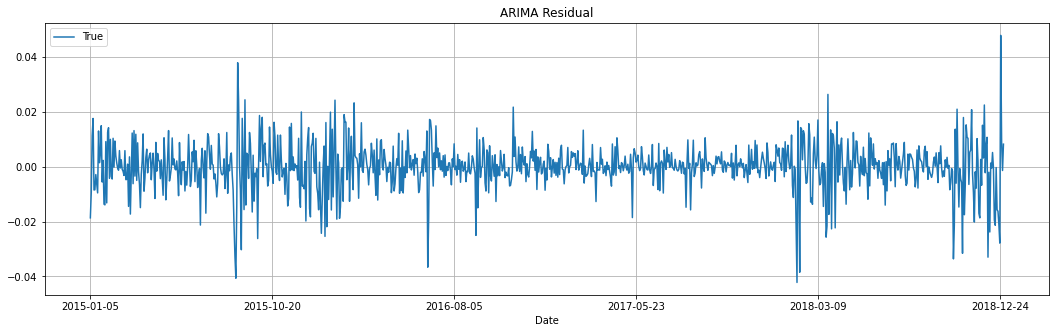

In [601]:
# Plot of Residue
#fig, axes = plt.subplots()
res = arima_res.flatten()

df_res = pd.DataFrame(res, columns=snp_arma.columns)
df_res.index = snp_arma.iloc[1:,:].index
df_res.plot(grid=True, label='Residual', title = 'ARIMA Residual', figsize=(18,5))

In [602]:
arima_para = ARIMA(snp_arma['True'].values, order=(1,1,0)).fit().arparams
print('The model parameter of ARIMA is: ', arima_para)

The model parameter of ARIMA is:  [-0.00875116]


### (4) Log of prices of ARIMA model

In [603]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ['True']

# The size of true value should match with the residual(size of 1005), therefore start from the second value of "arima_true"
arima_true = snp_arma['True'][1:]
arima_res = ARIMA(snp_arma['True'].values, order=(1,1,0)).fit().resid
arima_pre = arima_true - arima_res

log_true = np.log(arima_true)
log_pre = np.log(arima_pre)
res = log_true - log_pre

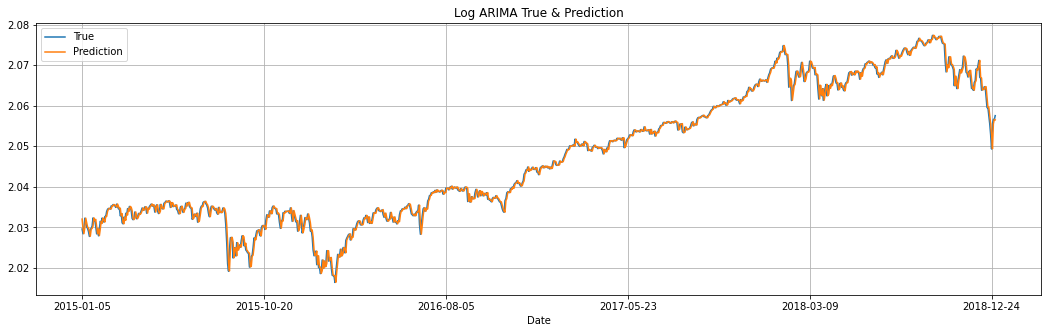

In [606]:
fig, axes = plt.subplots()

# True and Prediction signal plots
log_true.plot(grid=True, label='True', title = 'Log ARIMA True & Prediction',figsize=(18,5))
log_pre.plot(grid=True, label='Prediction',figsize=(18,5))
legend = plt.legend(['True', 'Prediction'])

<AxesSubplot:title={'center':'ARIMA Residual'}, xlabel='Date'>

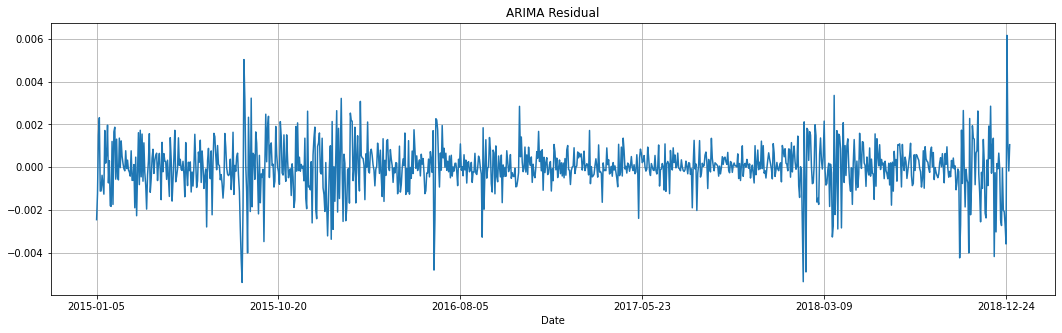

In [605]:
res.plot(grid=True, label='Residual', title = 'ARIMA Residual', figsize=(18,5))

## 1.3 Vector Autoregressive (VAR) Models
### (1) Concise matrix of VAR
The VAR model is generalized from the original AR model which used to capture the linear independencies among multiple time-series.
The **VAR(p)** is given by <br/>
$$ y_{t} = c + A_{1}y_{t-1} + A_{2}y_{t-2} + ... + A_{p}y_{t-p} + e_{t} $$
It can be transformed into a concise matrix form $$Y = BZ + U$$ 
<br/>
Where $Y \in \mathbb{R}^{K(T-P+1)}, B \in \mathbb{R}^{K(KP+1)}, Z \in \mathbb{R}^{(KP+1)(T-P+1)}$ and $U \in \mathbb{R}^{K(T-P+1)}$. <br/> <br/>
This is built up from first letting **B** to be:
$$ B = \begin{pmatrix}
c & A_{1} & A_{2} & ... & A_{p}
\end{pmatrix}$$

Therefore, the **Z** matrix will be 
$$ Z = \begin{pmatrix}
1 & y_{t-1} & y_{t-2} & ... & y_{t-p}
\end{pmatrix}$$
<br/>
Extend the matrix with p dimension, it will have the following exact form:
<br/>

$$ Z = \begin{pmatrix}
1 & 1 & 1 & ... & 1 \\
y_{p-1} & y_{p} & A_{p+1} & ... & A_{t-1}\\
... & ... & ... & ... & ... \\
y_{0} & y_{1} & y_{2} & ... & y_{t-p}
\end{pmatrix}$$
<br/>
<br/>
$$ \therefore U = \begin{pmatrix}
e_{p} & e_{p+1} & e_{p+2} & ... & e_{t}
\end{pmatrix}$$

### (2) Optimal B
B is estimated in the least-square fashion to minimize the error vector (**U**) of VAR.<br/>
According to the *Least Square Theorem*, the solution of $U = Y - BZ$ should be equal to $UU^{T} = (Y-BZ)(Y-BZ)^{T}$.

$$(Y-BZ)(Y-BZ)^{T} \\
= [YY^{T} - BZY^{T} - YZ^{T}B^{T} + BZZ^{T}B^{T}]$$

To minimize the error vector **U**, the derivative of $U^{T}U$ should be 0. First we find the derivative.<br/>
$$\frac{\partial }{\partial B} [YY^{T} - BZY^{T} - YZ^{T}B^{T} + BZZ^{T}B^{T}]\\
= [ZZ^{T} + (Z^{T}Z)^{T}]B - YZ^{T} - (Y^{T}Z)^{T}$$
<br/>
Therefore,<br/>
$$ 2ZZ^{T}B - 2YZ^{T} = 0\\
ZZ^{T}B = YZ^{T}$$<br/>
$$\therefore B_{opt} = YZ^{T}(ZZ^{T})^{-1}$$

### (3) Stable eigenvalues of A

For a stationary **VAR** process with order of 1,
$$ y_{t} = Ay_{t-1} + e_{t} $$
$$ y_{t-1} = Ay_{t-2} + e_{t-1} $$
$$ y_{t-2} = Ay_{t-3} + e_{t-2} $$
$$ y_{t-3} = Ay_{t-4} + e_{t-3} $$
<br/>
Substitute the $y_{t-1}$ into $y_{t}$ and $y_{t-1}$ can be replaced by $y_{t-2}$, $y_{t-2}$ can also be replaced by $y_{t-2}$ and so on. Therefore,
$$ y_{t} = A^{j}y_{t-j} + e_{t} + \sum_{i=1}^{j-1} A^{i}e_{t-i}$$ 


Eigenvalues $\lambda$s of **A** will have the property $ Ax = \lambda x$, this can be implied into the **y_{t}** formula above,<br/>

$$ A^{j}x = \lambda^{j} x $$
Substitute into the **y_{t}**
$$ y_{t} = \lambda^{j}y_{t-j} + e_{t} + \sum_{i=1}^{j} \lambda^{i} e_{t-i} $$
If the **VAR** process has a stationary time-series, the eigenvalues of **A** should be less than unity to make sure the value of $y_{t}$ will not go to infinity.

### (4) VAR portfolio with selected tickers

<AxesSubplot:title={'center':'Stock Tickers'}, xlabel='Date'>

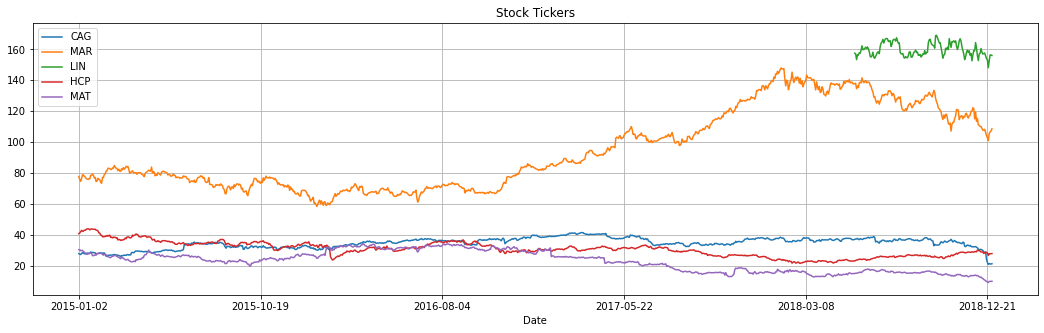

In [703]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import VAR

df = pd.read_csv('snp_allstocks_2015_2019.csv')
df = df.set_index('Date')

info = pd.read_csv('snp_info.csv')
info.drop(columns=info.columns[0], inplace=True)

# Take the time-series of stocks with serveal tickers
tickers = ['CAG', 'MAR', 'LIN', 'HCP', 'MAT']
stocks = df[tickers]
stocks.plot(grid=True, title='Stock Tickers',figsize=(18,5))

As the plot shown above, the time-series trends cannot be compared since ticker like *"LIN"* does not have any data before 2018. There detrending is used to remove all those gaps and it only shows the differences of all the tickers.

<AxesSubplot:title={'center':'Detrended Stock Tickers'}, xlabel='Date'>

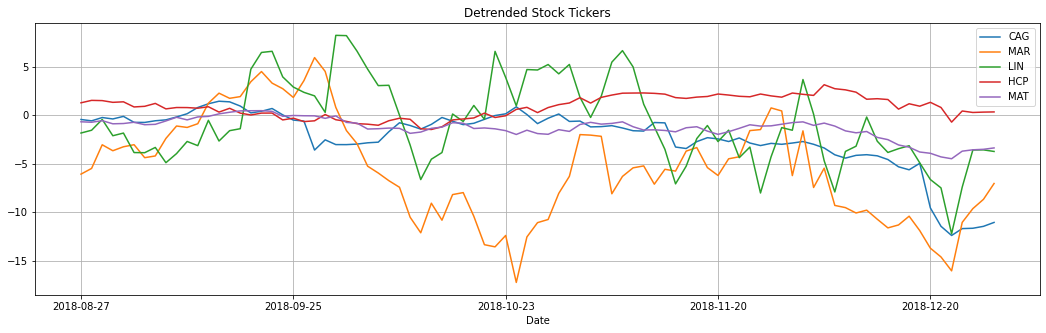

In [704]:
# Detrend a MA(66) model
stocks_ma = stocks.rolling(window=66).mean()
stocks_detrended = stocks.sub(stocks_ma).dropna()
stocks_detrended.plot(grid=True, title='Detrended Stock Tickers',figsize=(18,5))

In [609]:
# Fit into a VAR(1) model
model = VAR(stocks_detrended)
results = model.fit(1)
A = results.params[1:].values
results.params[1:]

CAG       MAR       LIN       HCP       MAT
L1.CAG  0.872786  0.113179 -0.281265  0.011912  0.058776
L1.MAR -0.063745  0.895820 -0.184820 -0.005004  0.022917
L1.LIN  0.000134 -0.111678  0.704023  0.004982 -0.025557
L1.HCP -0.084776 -0.083831 -0.401417  0.931708 -0.046406
L1.MAT  0.643072  0.094931  2.033036 -0.012884  0.802974

A good portfolio should show have stocks with low correlations and therefore is able to achieve diversification and minimize the risk of investment. <br/>
However, from the diagram above, strong correlations are not only shown between the past and present tickers (those are the numbers in the diagonal), but also shown up between different stocks. In particular, LIN shows an abnormally high correlation with MAT (with value 2.033036). It therefore might not be a very good portfolio. It can be enhanced by changing LIN with another tricker.

In [610]:
# Eigenvalues of A
eigA, _ = np.linalg.eig(A)
print(eigA)

[0.71449288+0.12927613j 0.71449288-0.12927613j 1.00635964+0.j
 0.86051894+0.j         0.91144512+0.j        ]


### (5) VAR portfolio with tickers according to particular sector

In [715]:
# It is hard to analysis and therefore transform into sectors
sector_eig = pd.DataFrame(columns=info['GICS Sector'].unique(), index=['mean eigen', 'median eigen'])
for sector in info['GICS Sector'].unique():
    tickers = info.loc[info['GICS Sector'] == sector]['Symbol'].tolist()
    stocks = df[tickers]
    #stocks.plot(grid=True, title='GICS stock tickers', figsize=(18,6), legend=False)
    # Detrend a MA(66) model
    stocks_ma = stocks.rolling(window=66).mean()
    stocks_detrended = stocks.sub(stocks_ma).dropna()
    
    # Implement with VAR
    model = VAR(stocks_detrended)
    results = model.fit(1)
    A = results.params[1:].values
    # Eigenvalues of A
    eigA, _ = np.linalg.eig(A)
    
    sector_eig[sector]['mean eigen'] = np.mean(abs(eigA))
    sector_eig[sector]['median eigen'] = np.median(abs(eigA))

In [716]:
sector_eig.T

mean eigen median eigen
Industrials              0.763932     0.824494
Health Care               0.62144     0.629848
Information Technology   0.809351     0.853701
Communication Services   0.926293     0.952246
Consumer Discretionary   0.810433     0.841535
Utilities                0.599877     0.608972
Financials               0.631218     0.667102
Materials                0.621833     0.636112
Real Estate              0.919369     0.937851
Consumer Staples         0.852121     0.916747
Energy                   0.930601     0.948361

The mean and median eigenvalues of the sector portfolio are drawn into a list. It it clear that there usually exist high correlations within the same industry as they are selling or produing substitues or complementary products which will be highly correlated with each other. Therefore it might not be a good choice to have a diversed portfolio within a single sector. Diversification should makes the portfolio to touch on different industries to lower the risk of investment.

# 2 Bond Prices
## 2.1 Examples of bond pricing

### (1) Percentage return
**Q:** An investor receives USD 1,100 in one year in return for an investment of USD 1,000 now. Calculate the percentage return per annum with: 

**(a)** Annual compounding: <br/>
$$ 1100 = 1000\times (1+r_{A}) $$
$$ r_{A} = 10.000\% $$

**(b)** Semiannual compounding: <br/>
$$ 1100 = 1000\times (1+\frac{r_{S}}{2})^{2} $$
$$ r_{S} = 9.762\% $$

**(c)** Monthly compounding: <br/>
$$ 1100 = 1000\times (1+\frac{r_{M}}{12})^{12} $$
$$ r_{M} = 9.569\% $$

**(d)** Continuous compounding: <br/>
$$ 1100 = 1000\times \exp(n\times r_{f}) $$ where n refers to n year. In this case, $ n = 1 $, therefore,<br/>
$$ r_{f} = \ln(\frac{1100}{1000}) = 9.531\% $$

### (2) Estimating interest rate
**Q:** What rate of interest with continuous compounding is equivalent to 15% per annum with monthly compounding?

$$ \exp(1\times r_{f}) = (1+\frac{15\%}{12})^{12} $$
$$ r_{f} = 14.907\% $$

### (3) Estimating interest payment
**Q:** A deposit account pays 12% per annum with continuous compounding, but interest is actually paid quarterly. How much interest will be paid each quarter on a USD 10,000 deposit? 

**First quarter** interest return:<br/>
$$ 10000 \times \exp(\frac{1}{4} \times 12\%)) - 10000 = 304.545 $$

**Second quarter** interest return:<br/>
$$ 10000 \times \exp(\frac{2}{4} \times 12\%)) - 10000 = 618.365 $$
Remove earnings from the first quarter, <br/>
$$ 618.365 - 304.545 = 313.820 $$

**Third quarter** interest return:<br/>
$$ 10000 \times \exp(\frac{3}{4} \times 12\%)) - 10000 = 941.743 $$
Remove earnings from the first and second quarters, <br/>
$$ 941.743 - 304.545 - 313.820 = 323.378 $$

**Fourth quarter** interest return:<br/>
$$ 10000 \times \exp(1 \times 12\%)) - 10000 = 1274.969 $$
Remove earnings from the first three quarters, <br/>
$$ 1274.969 - 304.545 - 313.820 - 323.378 = 333.226 $$

## 2.2 Forward rates

**Q:** Suppose that the one–year interest rate, r1 is 5%, and the two–year interest rate, r2 is 7%. If you invest
USD 100 for one year, your investment grows to 100×1.05 = USD 105; if you invest for two years, it grows
to 100×1.072 = USD 114.49. The extra return that you earn for that second year is 1.072/1.05−1 = 0.090,
or 9.0 %.


**(a)** Would you be happy to earn that extra 9% for investing for two years rather than one?

The forward rate for *n* years, $f_{n}$, is defined by: $ f_{n} = \frac{(1+r_{n})^{n}}{(1+r_{n-1})^{n-1}}-1 $. However, although the implied forward rate 9% is known at the beginning day, the one-year spot rate is unknown until the first year has passed. Therefore, the forward rate can be recognised as the spot rate expected over year 2. <br/>
From this point of view, investor cannot tell the difference and would feel okay towards both the two-year and one-year bonds.

**(b)** Comment on the 5%, 7%, and 9% investment strategies.

9% interest rate is the implied forward rate of the second year for a 5% investment to go from year 1 to year 2 and has the same return as a 2-year 7% investment. However, the actual forward rate might vary due to market imperfections. The best way to aviod this kind of risks is by diversification. Investors can invest other different kinds of stocks to lower the risk.

**(c)** Comment on the advantages and disadvantages of the forward rate of 9%.

Forward rate, which represents the "guessing" rate of return in year 2, will bring investors the risk of "unkown". It is possible that the interest rate rises in a large extent in the future (year 2) and therefore investors earn less in return. However, from the current perspective, the forward rate will give a higher return than investing one year and one year separately, which gives confidence of investments.

**(d)** How much would you need to go from 1y investment to 2y investment and what does it depend upon?

When change from 1-year investment to 2-year, the interest rate might vary because of the changes in market situation. This will depend on the the current spot rate of the stocks and can be worked out with the forward rate equation.

## 2.3 Duration of a coupon-bearing bond

### (a) Duration calculation

Duration (Macaulay Duration) measures the weighted average time to receipt of the bond's promised payments.<br/><br/>
$$ D = \frac{1\times PV(C_{1})}{PV} + \frac{2\times PV(C_{1})}{PV} + ... + \frac{T\times PV(C_{1})}{PV}$$
where $T = 7$ in this case.<br/><br/>
Therefore, the duration for 1% seven-year bond is $0.0124 + 0.0236 + 0.0337 + 0.0428 + 0.0510 + 0.0583 + 6.5377 = 6.7595$.

### (b) Modified duration

Modified duration is a measure of how much the bond price will vary when interest rate changes. It is equal to the duration over one plus the yield to maturity. <br/><br/>
$$ D_{M} = \frac{Duration}{1 + \frac{YTM}{n}} $$
where *n* refers to the number of coupon periods per year.<br/><br/>
It can also be recognized as the derivative of the present value of stock (PV) with respect to the change in Yield To Maturity,<br/><br/>
$$ \frac{d(PV)}{d(YTM)} = - D_{M}$$.

Therefore,  $ D_{M} = \frac{6.7595}{1+5\%} = 6.4376\% $.

Modified duartion is the adjusted version of the classical (Macaulay) duration. It takes the change in Yield To Maturity into accounts, measuring the sensitivity of the price of a stock towards the changing interest rate. Therefore, it can also be considered as a risk measure of investing a certain bond.

### (c) Importance of duration

Since (modified) duration shows how sensitive a bond is towards the changes in interest rate. Higher the duration (and modified duration), higher the present value of the stock. This means that coupon rate of the stock is low and the stock will be more volatile towards any change in interest rate and therefore with a higher risk.<br/>
It is the same when applied to pension plans. It therefore can give investors an expectation of to what extent the pension will vary in the future with some unexpected changes in interest rate.

## 2.4 Capital Asset Pricing Model (CAPM) and Arbitrage Pricing Theory (APT)

In [481]:
# Load the data
import numpy as np
import pandas as pd
df = pd.read_csv(r'fsp_case_31_BSD.csv', index_col = 0, header = [0,1])

### (1) Daily market return estimation

Missing data in the file is adjusted with the funciton 'fillna'. The daily market return is calculated by averaging the returns of all the companies and the graph is plotted below.

Text(0, 0.5, 'Returns')

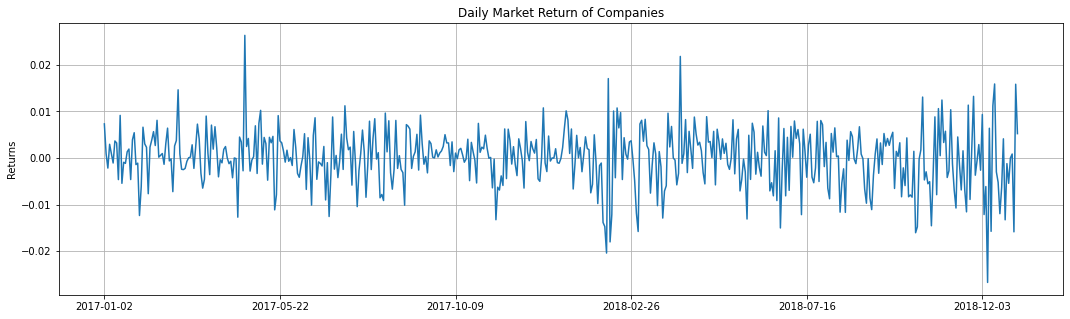

In [482]:
# Drop data
#df_clear = df['ret'].dropna(1)
df_clear = df['ret'].fillna(value=0, method=None)

meanret = np.mean(df_clear, 1)
#meanret = df_clear.mean(1)
meanret.plot(grid=True, title='Daily Market Return of Companies', figsize=(18,5)).set_ylabel('Returns')

In [483]:
print('Unweighted market return: ', meanret.mean())

Unweighted market return:  6.0947809821876025e-05


### (2) Estimating the rolling beta of companies

The stock $\beta$ is the sensitivity of a stock's return to the market's return. A higher $\beta$ means that the stock is more sensitive towards the market. It measures the risk level an investor will be exposed to if he/she holds a certain bond.

In [486]:
window = 22
#df_new = df.fillna(value=0, method=None)

#column = len(df_clear['ret'].columns)
column = df_clear.shape[1]
rows = len(df_clear)-22+1

beta = np.zeros((rows, column))

In [487]:
for col in range (column):
    for row in range (rows):
        cov = df_clear.iloc[row:row+window, col].cov(meanret.iloc[row:row+window])
        beta[row,col] = cov/meanret.iloc[col:col+window].var()

In [ ]:
beta

Text(0, 0.5, 'Betas')

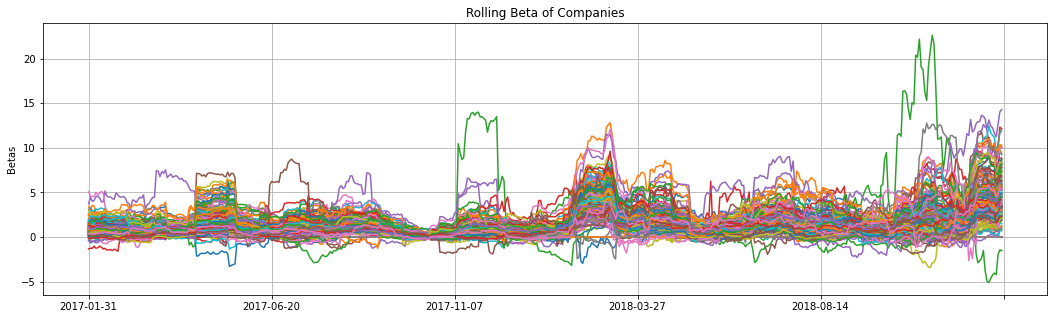

In [488]:
df_beta = pd.DataFrame(beta, columns=df_clear.columns)
df_beta.index = df_clear.iloc[21:,:].index

df_beta.plot(grid=True, title='Rolling Beta of Companies', figsize=(18,5), legend=False).set_ylabel('Betas')

### (3) Cap-weighted return estimation

In [489]:
mcapret = np.multiply(df['mcap'], df['ret'])
sumcap = df['mcap'].sum(1)

# To make the data divisible, first sum up
sumcapret = mcapret.sum(1)
rm = sumcapret/sumcap

Text(0, 0.5, 'Returns')

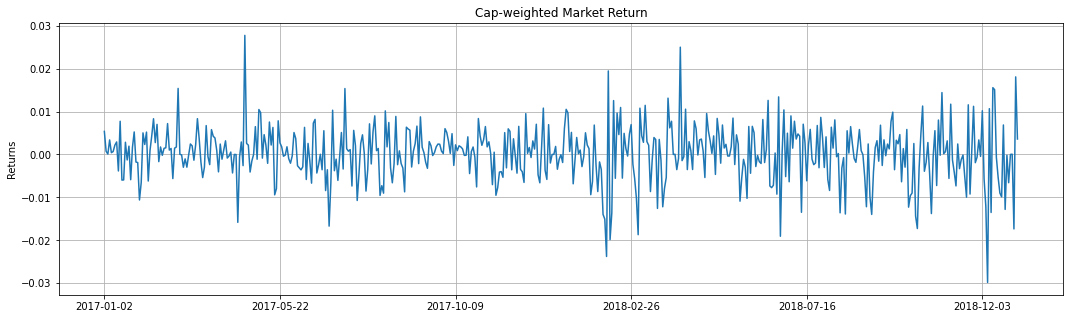

In [492]:
rm.plot(grid=True, title='Cap-weighted Market Return', figsize=(18,5), legend=False).set_ylabel('Returns')

In [493]:
print('Cap-weighted market return: ', rm.mean())

Cap-weighted market return:  0.00019714725583991856


The mean weighted market return shows a big difference from the previous unweighted return. The unweighted tends to be more volatile in theory. This is affected by smaller-cap stocks which tends to have higher volatility than large companies. Unweighted return generally has a greater tilt towards those small-cap stocks compared to the weighted market return.

### (4) Weighted rolling beta of companies

In [494]:
window = 22

# Set up array dimensions
column = df_clear.shape[1]
rows = len(df_clear)-22+1

new_beta = np.zeros((rows, column))

In [495]:
for col in range (column):
    for row in range (rows):
        cov = df_clear.iloc[row:row+window, col].cov(rm.iloc[row:row+window])
        new_beta[row,col] = cov/rm.iloc[col:col+window].var()

Text(0, 0.5, 'Betas')

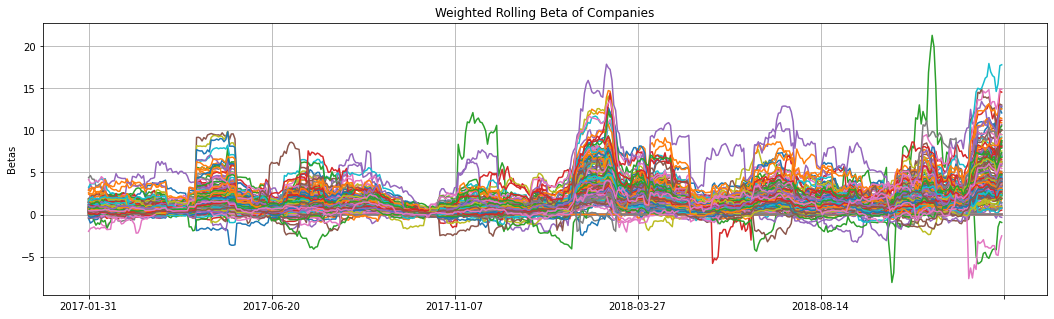

In [496]:
# Transform into dataframe
df_newbeta = pd.DataFrame(new_beta, columns=df_clear.columns)
df_newbeta.index = df_clear.iloc[21:,:].index

df_newbeta.plot(grid=True, title='Weighted Rolling Beta of Companies', figsize=(18,5), legend=False).set_ylabel('Betas')

### 2.4.5 APT model

#### (a) APT factors estimation

In [556]:
from sklearn.linear_model import LinearRegression

# Market beta
#bm = df_newdata
bm = new_beta.T
#bm.shape = (500, 157)

# Return
#ri = df_clear.copy()

# Only pick the returns with market beta
ri = df['ret'].iloc[21:,:].T
ri = ri.fillna(value=0, method=None)

# Exposure to size
bs = df['mcap'].iloc[21:,:].rolling(22).mean().T
bs = np.log(bs)
bs = bs.fillna(value=0, method=None)


In [557]:
# Two-factor model
a = np.zeros((1,1))
res = np.zeros((len(ri.columns),1))
rmrs = np.zeros((2,1)) # 2 refers to factor

for i in range (len(ri.columns)):
    x = np.concatenate([[bm[:,i],bs.values[:,i]]]).T
    #x = pd.concat([bm, bs])
    y = ri.values[:,[i]]
    reg = LinearRegression().fit(x, y)
    
    atemp = reg.intercept_.T
    a = np.append(a, atemp)
    
    temp = reg.coef_
    rmrs = np.append(rmrs, temp.T, axis=1)
    
    #restemp
    res = np.append(res, reg.predict(x) - ri.values[:,[i]])
    
rm0 = rmrs[0,:]
rs0 = rmrs[1,:]
# Apply the formula
ri0 = a[1:] + np.multiply(rm0[1:], bm) + np.multiply(rs0[1:], bs)
res = ri - ri0

In [558]:
rs0[1:].shape

(500,)

<AxesSubplot:title={'center':'Asset constant alpha'}>

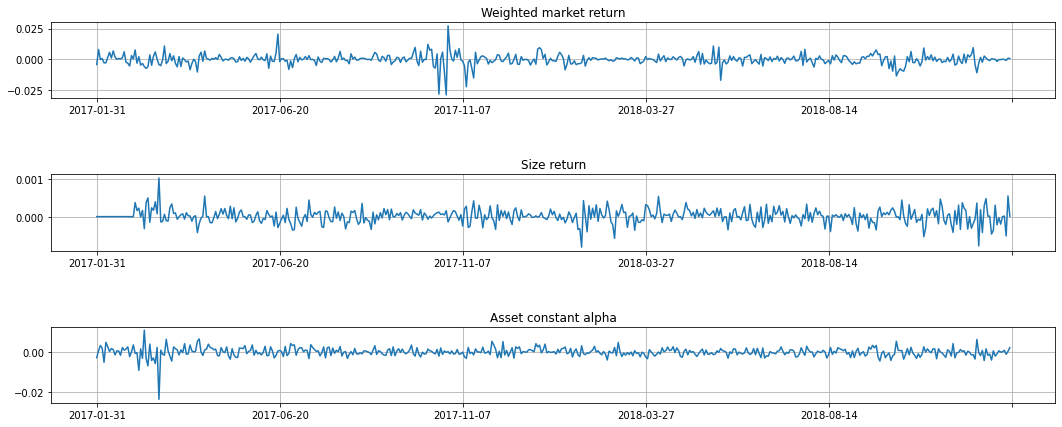

In [559]:
df_rm0 = pd.DataFrame(rm0[1:], columns=['Rm'])
df_rm0.index = df_clear.iloc[21:,:].index

df_rs0 = pd.DataFrame(rs0[1:], columns=['Rs'])
df_rs0.index = df_clear.iloc[21:,:].index

df_a = pd.DataFrame(a[1:], columns=['a'])
df_a.index = df_clear.iloc[21:,:].index

fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.subplots_adjust(hspace=1)

df_rm0.plot(grid=True, ax=ax1, label='Rm', title='Weighted market return', legend=False, figsize=(18,7))
df_rs0.plot(grid=True, ax=ax2, label='Rs', title='Size return', legend=False, figsize=(18,7))
df_a.plot(grid=True, ax=ax3, label='a', title='Asset constant alpha', legend=False, figsize=(18,7))

In [ ]:
res.plot(grid=True, label='Residual', title = 'Regrssion residual', legend=False, figsize=(18,6))

#### (b) Factors analysis

From the figures shown in part (a), the asset constant, alpha, generally has a much larger value than the other two return factors (Rm and Rs). Therefore, it is an essential factor in return analysis. Rm and Rs are also important. From the magnitude perspective, Rm is usually larger than the value of Rs.<br/>
All of those factors are fluctating up and down with a zero mean approximately. However, Rm (market return) has the biggest varation trend, which may refer to the randomness of the market.

In [ ]:
df_para = pd.DataFrame(index=['Rm','Rs','a'], columns=['mean', 'std'])

df_para.loc['Rm'] =[df_rm0.mean().values, df_rm0.std().values]
df_para.loc['Rs'] =[df_rs0.mean().values, df_rs0.std().values]
df_para.loc['a'] =[df_a.mean().values, df_a.std().values]
df_para

#### (c) Specific return

In [ ]:
for company in res.columns:
    plt.plot(res[company], ri[company], 'o')

plt.title('Scatter Plot of Ri and specific returns')
plt.xlabel('Specific returns')
plt.ylabel('Ri')
plt.grid()

The figure above shows a strong correlation between Ri and the specific returns $\epsilon_{i}$. Specific return is also called the residual of the APT 2-factor model. This shows "how much difference is" from Ri after evaluting the factors Rm, Rs and a. A small difference between Ri and specific return shows that the 2-factor model with Rm and Rs is not strong enough to predict the investment return. The numerical calculation is ran below.

In [ ]:
corr = np.zeros(ri.shape[0])

for i in range (ri.shape[0]):
    temp = np.corrcoef(res.T.iloc[:,i],ri.values.T[:,i])[0,1]
    corr[i] = temp

In [ ]:
df_corr = pd.DataFrame(corr, columns=['corr'])
df_corr.index = ri.index

df_corr.plot(grid=True, title='Correlation between Ri and specific returns', figsize=(18,5), legend=False)

#### (d) Covariance of Rm and Rs

Covariance is calculated between Rm and Rs in R matrix. The magnitude and stability are plotted below, which shows a high trend of instability of the covariance. The 2-factor APT model might not be a good indicator for predicting or evaluating the stock market as a result. 

In [ ]:
window = 22
R = pd.DataFrame(index=df_rm0.index, columns=['Rm', 'Rs'])
R['Rm'] = df_rm0
R['Rs'] = df_rs0
#Rm = rm0[1:].reshape(500,1)
#Rs = rs0[1:].reshape(500,1)
#R = np.append(Rm,Rs,axis=1)

In [ ]:
rolling = R.index[21:]
cov = []

for i in rolling:
    tmp = R[:i].iloc[-window:]
    rcov = np.cov(tmp.T)
    cov.append(rcov)

In [ ]:
len(cov)

In [ ]:
# len(cov)=479
magnitude = np.zeros(479)
stability = np.zeros(479)

for i in range(1, 479):
    # get the magnitude of the covariance
    mcov = cov[i]
    lastcov = cov[i-1]
    magnitude[i]=(np.linalg.norm(mcov))
    
    # get the stability, percentage change in cov
    stab = abs((mcov - lastcov)/(lastcov))
    stability[i]=(100*np.mean(stab))  

In [ ]:
df_mag = pd.DataFrame(magnitude, columns=['covariance magnitude'])
df_mag.index = R.index[21:]

df_mag.plot(grid=True, title='Covariance norm magnitudes', figsize=(18,5), legend=False)

In [ ]:
df_stab = pd.DataFrame(stability, columns=['covariance stability'])
df_stab.index = R.index[21:]

df_stab.plot(grid=True, title='Covariance stability', figsize=(18,5), legend=False)

#### (e) Specfic returns analysis

In [567]:
e = res.to_numpy()
e0 = e.T
e0.shape

(500, 157)

In [570]:
# Covariance of the specific returns
e_cov = np.cov(e)
e_cov.shape

(157, 157)

In [879]:
e_cov

array([[ 3.02470341e-04, -1.54268352e-05, -2.56568592e-06, ...,
         1.81106086e-05, -2.52526510e-05, -9.69364527e-06],
       [-1.54268352e-05,  1.07291925e-04, -7.75519859e-06, ...,
        -2.31827234e-05,  9.89767769e-06,  2.09392277e-05],
       [-2.56568592e-06, -7.75519859e-06,  8.79017761e-05, ...,
        -1.75052287e-06,  3.98666926e-07, -4.01443323e-06],
       ...,
       [ 1.81106086e-05, -2.31827234e-05, -1.75052287e-06, ...,
         1.17557277e-04, -1.58149296e-05, -1.09855450e-05],
       [-2.52526510e-05,  9.89767769e-06,  3.98666926e-07, ...,
        -1.58149296e-05,  6.99270633e-05,  1.18495161e-05],
       [-9.69364527e-06,  2.09392277e-05, -4.01443323e-06, ...,
        -1.09855450e-05,  1.18495161e-05,  2.52598452e-04]])

In [876]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcae = pca.fit(e)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.07075591 0.05182131]
[1.04753621 0.89648265]


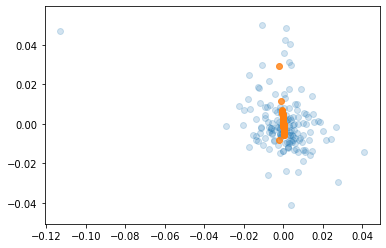

In [878]:
pca_e = pca.transform(e)
e_new = pca.inverse_transform(pca_e)
plt.scatter(e[:, 0], e[:, 1], alpha=0.2)
plt.scatter(e_new[:, 0], e_new[:, 1], alpha=0.8)
plt.axis('equal');

In [872]:
eig_val, eig_vec = np.linalg.eigh(e_cov)
tmp = eig_val[-1] / sum(eig_val)
pc1 = round(tmp, 2)
print('The first principle component is', pc1)

The first principle component is 0.07


PC1 is the line in the variable space that best approximates the data in the least squares sense. 

# 3 Portfolio Optimization
## 3.1 Adaptive minimum-variance portfolio optimization

### (1) Lagrange optimization

The main propose of the optimization problem is to minimize the value of *w* (weight) and therefore to reach a minimum value of variance and the level of investment risk, where variance $\sigma^{2} =\mathbf{w^{T}Cw}$. *C* refers to the covariance matrix of various assets.

The Largrangian optimization is 
$$ L = \frac{1}{2} \mathbf{w^{T}Cw} - \lambda (\mathbf{w^{T}1}-1)$$

Assume *C* is a non-singular matrix and it is invertible. Differentiate the Largrangian equation with respect to *w* and $\lambda$. <br/><br/>
$$ \frac{dL}{d\mathbf{w}} = \mathbf{Cw} - \lambda \mathbf{1} $$<br/>
$$ \frac{dL}{d\lambda} = -\mathbf{w^{T}1} + 1 $$

Equate the derivatives into 0 to find the optimal solution.<br/><br/>
$$ \mathbf{Cw - \lambda 1} = 0 $$<br/>
$$\therefore \mathbf{w_{opt}} = \mathbf{\lambda 1C^{-1}}$$<br/>
$$ -\mathbf{w^{T}1} + 1 = 0 $$<br/>
$$\therefore 1 = \mathbf{w^{T}1}$$

Replace $\mathbf{w}$ with $\mathbf{\lambda 1C^{-1}}$.
$$ 1 = \mathbf{(\lambda 1C^{-1})}^{T} \mathbf{1} = \mathbf{\lambda 1^{T} (C^{-1})^{T} 1} $$<br/>
$$ \therefore \lambda = \frac{1}{\mathbf{1^{T} (C^{-1})^{T} 1}}$$

Put the $\lambda$ back into $\mathbf{w}$.
$$ \mathbf{w_{opt}} = \frac{1}{\mathbf{1^{T} (C^{-1})^{T} 1}} \mathbf{1C^{-1}} $$

As variance is $\sigma^{2} =\mathbf{w^{T}Cw}$,
$$ \sigma^{2} =\mathbf{w^{T}Cw} =  (\frac{1}{\mathbf{1^{T} (C^{-1})^{T} 1}})^{2} \mathbf{(C^{-1}) 1}^{T} \mathbf{C (C^{-1}) 1}$$

$$  = (\frac{1}{\mathbf{1 1^{T} (C)^{-1} (C^{-1})^{T} 1^{T} 1}})^{2} \mathbf{(C^{-1}) 1}^{T} \mathbf{C (C^{-1}) 1} $$

$$ \therefore \sigma^{2} = \frac{1}{\mathbf{1^{T} (C^{-1})^{T} 1}} $$

### (2) Minimum variance portfolio

As shown in the plots below, in the minimum variance porfolio with training data, the returns are relatively stable. It shows that the stock has a low volatility and the cumulative return is gradually increasing without too much violation. <br/><br/>
In contrast, the returns in equally-weighted portfolio fluctuate in a larger extent. Its cumulative returns shows big jumps between gaining and lossing money while investing. This helps to reconfirm the importance of having a weighted portfolio with minimum variance for investment.

In [1]:
import pandas as pd 
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'fsp_case_31_BSD.csv',index_col=0,header=[0,1])

# Pick the last 10 stocks
df = df['ret'].iloc[:,-10:]
test = df.iloc[:1,:]

In [3]:
# Divide up the training and testing data
df_train = df.iloc[:260,:]
df_test = df.iloc[260:,:]
df_train

cmp_id       G_TUIGR   G_UNANA   G_UPMFH   G_VIEFP   G_VIVFP    G_VLVY  \
2017-01-02  0.028915  0.003451  0.005998  0.010820  0.002216  0.001880   
2017-01-03 -0.003285 -0.006752  0.004685 -0.011927  0.000829  0.005629   
2017-01-04  0.001099  0.001539 -0.008478 -0.003404  0.005522  0.004664   
2017-01-05  0.003658  0.001409  0.002993 -0.018945  0.001647 -0.001857   
2017-01-06 -0.008382 -0.004348  0.000000 -0.010130  0.004934  0.000000   
...              ...       ...       ...       ...       ...       ...   
2017-12-25  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2017-12-26  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2017-12-27  0.004389  0.000000  0.000000 -0.001861 -0.000659 -0.028750   
2017-12-28  0.002331 -0.005055 -0.006063 -0.006296 -0.006593  0.003217   
2017-12-29 -0.001744 -0.006033 -0.012200 -0.001643 -0.007965 -0.020526   

cmp_id         G_VOD      G_VW   G_WKLNA   G_WPPLN  
2017-01-02  0.000000  0.030347  0.010604  0.000000  
2017-01-03  0.012760  0.020227 -0.006468  0.004956  
2017-01-04  0.016304 -0.011826 -0.004051 -0.007124  
2017-01-05  0.018230  0.008448  0.013219  0.009934  
2017-01-06  0.009071 -0.004537 -0.003584  0.005464  
...              ...       ...       ...       ...  
2017-12-25  0.000000  0.000000  0.000000  0.000000  
2017-12-26  0.000000  0.000000  0.000000  0.000000  
2017-12-27 -0.007207 -0.000588 -0.004749 -0.002974  
2017-12-28  0.000427  0.000589 -0.004431  0.007457  
2017-12-29  0.002988 -0.007647 -0.007646 -0.007402  

[260 rows x 10 columns]

Text(0, 0.5, 'Returns')

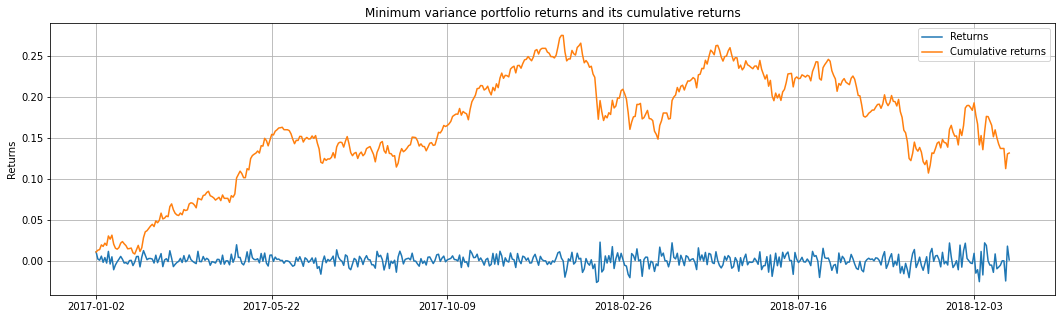

In [382]:
cov_train = df_train.cov()
onem = np.ones((df_train.shape[1],1))

# Implement the lambda and optimal w with equation from (1)
lamb = 1/(onem.T.dot(np.linalg.inv(cov_train).T).dot(onem))
w_opt = lamb*(np.linalg.inv(cov_train).dot(onem))

# Reshape to single array for calculation
w_opt = w_opt.reshape(-1,)
#w_opt
minvar_port = (w_opt*df).sum(1)

minvar_port.plot(grid=True, label='Returns', figsize=(18,5), legend=True).set_ylabel('Returns')
minvar_port.cumsum().plot(grid=True, label='Cumulative returns', title='Minimum variance portfolio returns and its cumulative returns', figsize=(18,5), legend=True).set_ylabel('Returns')

Text(0, 0.5, 'Returns')

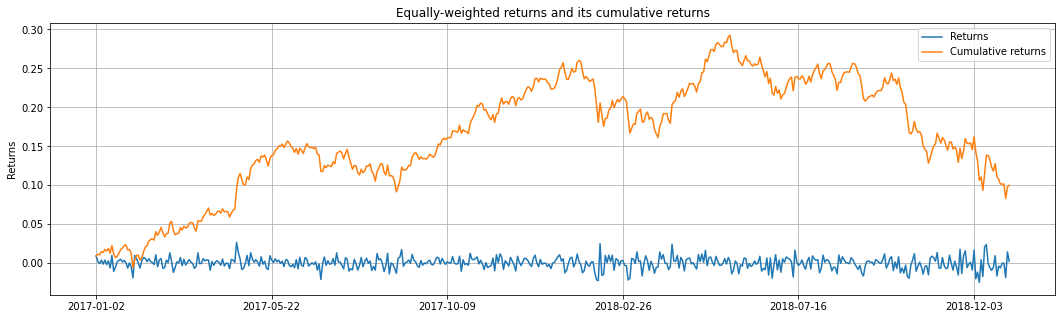

In [383]:
# Test data with equal weight
equalw = df.mean(1)

equalw.plot(grid=True, label='Returns', title='Equally-weighted returns', figsize=(18,5), legend=True)
equalw.cumsum().plot(grid=True, label='Cumulative returns', title='Equally-weighted returns and its cumulative returns', figsize=(18,5), legend=True).set_ylabel('Returns')

In [384]:
# Variance of equal weight test data
equalw_var = equalw.std()**2

# Variance of minimum var portfolio (training data)
minvar_var = minvar_port.std()**2
# Compute the theoritical weighted variance from (1)
theo_var = 1/(onem.T.dot(np.linalg.inv(cov_train).T).dot(onem))

print('The variance of equally-weighted portfolio is ', equalw_var)
print('The variance of minimum variance portfolio is ', minvar_var, 'with the theoretical value: ', theo_var)

The variance of equally-weighted portfolio is  5.8787222993605845e-05
The variance of minimum variance portfolio is  5.570996982423395e-05 with the theoritical value:  [[2.86162941e-05]]


### (3) Adaptive time-varying minimum variance portfolio

In [438]:
# Choose window size of 22 as usual
window = 22
adavar_port = pd.Series(index=df.iloc[window:,:].index)
adaw_opt = np.zeros((df.shape[0]-window,df.shape[1]))
length = df.shape[0]
onem = np.ones((df.shape[1],1))

for i in range(length-window):
    df_win = df.iloc[i:window+i,:]

    winmean = df_win.mean()
    csigma = np.dot((df_win-winmean).T, df_win-winmean)
    c = csigma/window
    adaw_opt[[i],:] = (np.linalg.inv(c).dot(onem)).T/(onem0.T.dot(np.linalg.inv(c).T).dot(onem))

adavar_port = np.sum(np.multiply(df.iloc[window:,:],adaw_opt),axis=1)

Text(0, 0.5, 'Returns')

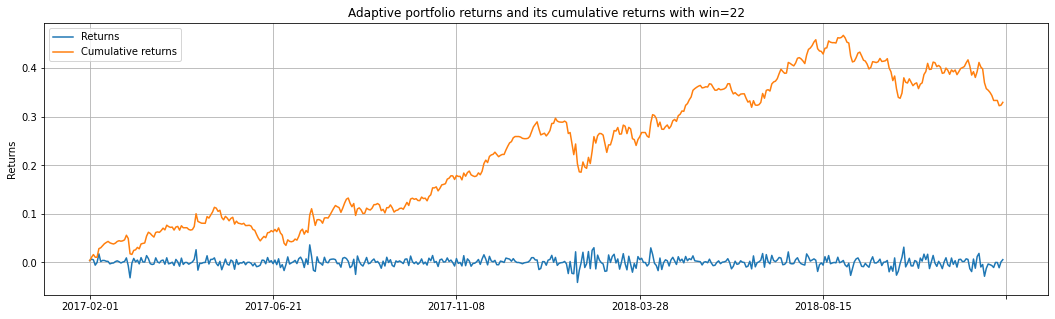

In [439]:
adavar_port.plot(grid=True, label='Returns', figsize=(18,5), legend=True)
adavar_port.cumsum().plot(grid=True, label='Cumulative returns', title='Adaptive portfolio returns and its cumulative returns with win=22', figsize=(18,5), legend=True).set_ylabel('Returns')

In [440]:
# Variance of adaptive var portfolio
ada_var = adavar_port.std()**2
print('The variance of adaptive portfolio with window 22 is ', ada_var)
print('The variance of equally-weighted portfolio is ', equalw_var)
print('The variance of minimum variance portfolio is ', minvar_var, 'with the theoritical value: ', theo_var)

The variance of adaptive portfolio with window 22 is  8.278224176095072e-05
The variance of equally-weighted portfolio is  5.8787222993605845e-05
The variance of minimum variance portfolio is  5.570996982423395e-05 with the theoritical value:  [[2.86162941e-05]]


Text(0, 0.5, 'Returns')

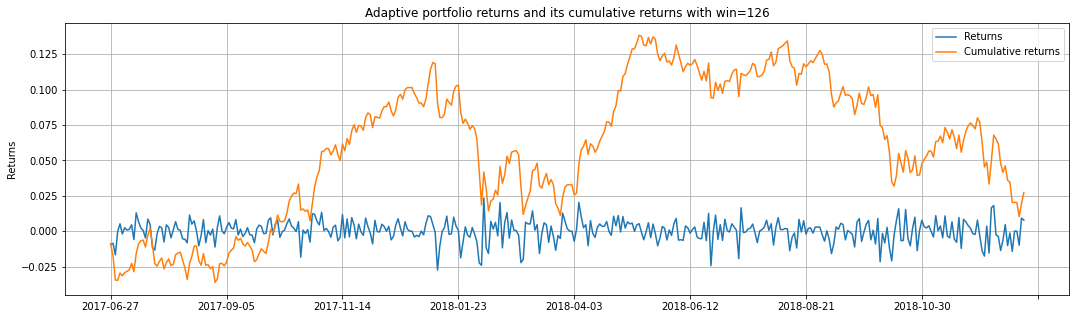

In [452]:
# Choose window size of 126, half of the year
window1 = 126
adavar_port1 = pd.Series(index=df.iloc[window1:,:].index)
adaw_opt1 = np.zeros((df.shape[0]-window1,df.shape[1]))
length = df.shape[0]
onem = np.ones((df.shape[1],1))

for i in range(length-window1):
    df_win1 = df.iloc[i:window1+i,:]

    winmean1 = df_win1.mean()
    csigma1 = np.dot((df_win1-winmean1).T, df_win1-winmean1)
    c1 = csigma1/window1
    adaw_opt1[[i],:] = (np.linalg.inv(c1).dot(onem)).T/(onem0.T.dot(np.linalg.inv(c1).T).dot(onem))

adavar_port1 = np.sum(np.multiply(df.iloc[window1:,:],adaw_opt1),axis=1)
adavar_port1.plot(grid=True, label='Returns', figsize=(18,5), legend=True)
adavar_port1.cumsum().plot(grid=True, label='Cumulative returns', title='Adaptive portfolio returns and its cumulative returns with win=126', figsize=(18,5), legend=True).set_ylabel('Returns')

In [453]:
# Variance of adaptive var portfolio
ada_var1 = adavar_port1.std()**2
print('The variance of adaptive portfolio with window 126 is ', ada_var1)

The variance of adaptive portfolio with window 126 is  5.860441868835754e-05


Text(0, 0.5, 'Returns')

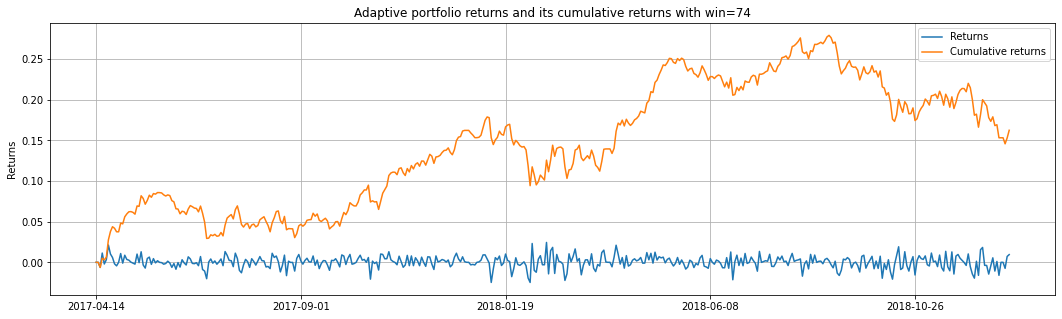

In [454]:
# Choose window size of 126, half of the year
window2 = 74
adavar_port2 = pd.Series(index=df.iloc[window2:,:].index)
adaw_opt2 = np.zeros((df.shape[0]-window2,df.shape[1]))
length = df.shape[0]
onem = np.ones((df.shape[1],1))

for i in range(length-window2):
    df_win2 = df.iloc[i:window2+i,:]

    winmean2 = df_win2.mean()
    csigma2 = np.dot((df_win2-winmean2).T, df_win2-winmean2)
    c2 = csigma2/window2
    adaw_opt2[[i],:] = (np.linalg.inv(c2).dot(onem)).T/(onem0.T.dot(np.linalg.inv(c2).T).dot(onem))

adavar_port2 = np.sum(np.multiply(df.iloc[window2:,:],adaw_opt2),axis=1)
adavar_port2.plot(grid=True, label='Returns', figsize=(18,5), legend=True)
adavar_port2.cumsum().plot(grid=True, label='Cumulative returns', title='Adaptive portfolio returns and its cumulative returns with win=74', figsize=(18,5), legend=True).set_ylabel('Returns')

In [456]:
# Variance of adaptive var portfolio
ada_var2 = adavar_port2.std()**2
print('The variance of adaptive portfolio with window 74 is ', ada_var2)

The variance of adaptive portfolio with window 74 is  5.813969573953392e-05


Compared the window size of 22, 74 and 126 for the adaptive portfolio returns, there is a large difference between the results and their variances. As the window size gets larger, the returns would show a larger fluctuations consequently and its corresponding variance will get larger. Therefore, the performance of the adaptive portfolio returns might be affected by the window size of the model. The good news is, compared to the other two kinds of portfolio, adaptive portfolio has the lowest variance when its window size is small enough. <br/><br/>
In terms of returns, adative portfolio shows an overall opitmistic growing returns which performs much better than the other two portfolios (equally-weighted and minimum variance). The model may be further improved by minimizing the window size of portfolio and with frequently adjusted weights.

# 4 Robust Statistics and Non Linear Methods

## 4.1 Data Import and Exploratory Data Analysis

In [307]:
# Read all the data
AAPL = pd.read_csv('All_Datasets_FSPMI/AAPL.csv', index_col=0)

IBM = pd.read_csv('All_Datasets_FSPMI/IBM.csv', index_col=0)

JPM = pd.read_csv('All_Datasets_FSPMI/JPM.csv', index_col=0)

DJI = pd.read_csv('All_Datasets_FSPMI/DJI.csv', index_col=0)

### (1) Basic statistics of the companies

In [335]:
AAPL_mean = AAPL.mean()
AAPL_median = AAPL.median()
AAPL_std = AAPL.std()

IBM_mean = IBM.mean()
IBM_median = IBM.median()
IBM_std = IBM.std()

JPM_mean = JPM.mean()
JPM_median = JPM.median()
JPM_std = JPM.std()

DJI_mean = DJI.mean()
DJI_median = DJI.median()
DJI_std = DJI.std()

#AAPL

In [329]:
aapl_data = {'Mean':[AAPL_mean.loc['Open'], AAPL_mean.loc['High'], AAPL_mean.loc['Low'], AAPL_mean.loc['Close'], AAPL_mean.loc['Adj Close'], AAPL_mean.loc['Volume']], 'Median':[AAPL_median.loc['Open'], AAPL_median.loc['High'], AAPL_median.loc['Low'], AAPL_median.loc['Close'], AAPL_median.loc['Adj Close'], AAPL_median.loc['Volume']], 'Stddev':[AAPL_std.loc['Open'], AAPL_std.loc['High'], AAPL_std.loc['Low'], AAPL_std.loc['Close'], AAPL_std.loc['Adj Close'], AAPL_std.loc['Volume']]}

In [333]:
aapl_stats = pd.DataFrame(aapl_data, index=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
aapl_stats

Mean        Median        Stddev
Open       1.876867e+02  1.862900e+02  2.214562e+01
High       1.895618e+02  1.874000e+02  2.228158e+01
Low        1.858237e+02  1.849400e+02  2.200880e+01
Close      1.877120e+02  1.861200e+02  2.216072e+01
Adj Close  1.861743e+02  1.843518e+02  2.190466e+01
Volume     3.270475e+07  2.918400e+07  1.417972e+07

In [336]:
ibm_data = {'Mean':[IBM_mean.loc['Open'], IBM_mean.loc['High'], IBM_mean.loc['Low'], IBM_mean.loc['Close'], IBM_mean.loc['Adj Close'], IBM_mean.loc['Volume']], 'Median':[IBM_median.loc['Open'], IBM_median.loc['High'], IBM_median.loc['Low'], IBM_median.loc['Close'], IBM_median.loc['Adj Close'], IBM_median.loc['Volume']], 'Stddev':[IBM_std.loc['Open'], IBM_std.loc['High'], IBM_std.loc['Low'], IBM_std.loc['Close'], IBM_std.loc['Adj Close'], IBM_std.loc['Volume']]}
ibm_stats = pd.DataFrame(ibm_data, index=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
ibm_stats

Mean        Median        Stddev
Open       1.384544e+02  1.428100e+02  1.211431e+01
High       1.394921e+02  1.439900e+02  1.191308e+01
Low        1.373292e+02  1.420600e+02  1.220463e+01
Close      1.383631e+02  1.427100e+02  1.202812e+01
Adj Close  1.349028e+02  1.385664e+02  1.067165e+01
Volume     5.198937e+06  4.237900e+06  3.328956e+06

In [337]:
jpm_data = {'Mean':[JPM_mean.loc['Open'],JPM_mean.loc['High'], JPM_mean.loc['Low'], JPM_mean.loc['Close'], JPM_mean.loc['Adj Close'], JPM_mean.loc['Volume']], 'Median':[JPM_median.loc['Open'], JPM_median.loc['High'], JPM_median.loc['Low'], JPM_median.loc['Close'], JPM_median.loc['Adj Close'], JPM_median.loc['Volume']], 'Stddev':[JPM_std.loc['Open'], JPM_std.loc['High'], JPM_std.loc['Low'], JPM_std.loc['Close'], JPM_std.loc['Adj Close'], JPM_std.loc['Volume']]}
jpm_stats = pd.DataFrame(jpm_data, index=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
jpm_stats

Mean        Median        Stddev
Open       1.087077e+02  1.091800e+02  5.359081e+00
High       1.096521e+02  1.105300e+02  5.202870e+00
Low        1.076830e+02  1.077900e+02  5.432537e+00
Close      1.086066e+02  1.090200e+02  5.300480e+00
Adj Close  1.072626e+02  1.072193e+02  4.833316e+00
Volume     1.470069e+07  1.363300e+07  5.349771e+06

In [338]:
dji_data = {'Mean':[DJI_mean.loc['Open'],DJI_mean.loc['High'], DJI_mean.loc['Low'], DJI_mean.loc['Close'], DJI_mean.loc['Adj Close'], DJI_mean.loc['Volume']], 'Median':[DJI_median.loc['Open'], DJI_median.loc['High'], DJI_median.loc['Low'], DJI_median.loc['Close'], DJI_median.loc['Adj Close'], DJI_median.loc['Volume']], 'Stddev':[DJI_std.loc['Open'], DJI_std.loc['High'], DJI_std.loc['Low'], DJI_std.loc['Close'], DJI_std.loc['Adj Close'], DJI_std.loc['Volume']]}
dji_stats = pd.DataFrame(dji_data, index=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
dji_stats

Mean        Median        Stddev
Open       2.500126e+04  2.502558e+04  8.588347e+02
High       2.514204e+04  2.512410e+04  8.152040e+02
Low        2.484600e+04  2.488304e+04  9.033022e+02
Close      2.499915e+04  2.504429e+04  8.591321e+02
Adj Close  2.499915e+04  2.504429e+04  8.591321e+02
Volume     3.328894e+08  3.137900e+08  9.407804e+07

In [612]:
# Append the returns to dataframes
AAPL['Returns'] = AAPL['Adj Close'].pct_change()
IBM['Returns'] = IBM['Adj Close'].pct_change()
JPM['Returns'] = JPM['Adj Close'].pct_change()
DJI['Returns'] = DJI['Adj Close'].pct_change()

### (2) Adj closes and returns

Text(0, 0.5, 'Returns')

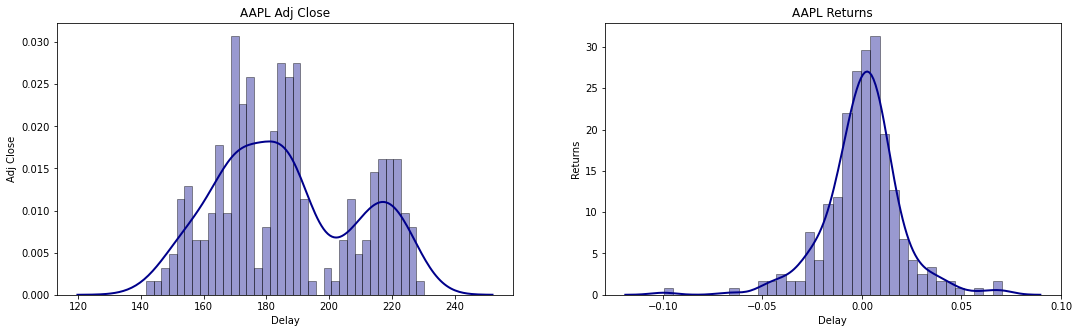

In [477]:
import seaborn as sns
aaplplot = plt.figure(figsize=(18,5))
aaplplot.set_rasterized(True)

ax1 = aaplplot.add_subplot(121)
ax1.set_rasterized(True)
sns.distplot(AAPL['Adj Close'], hist=True, kde=True, ax=ax1, bins=int(180/5), color='darkblue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('AAPL Adj Close')
plt.xlabel('Delay')
plt.ylabel('Adj Close')

ax2 = aaplplot.add_subplot(122)
ax2.set_rasterized(True)
sns.distplot(AAPL['Returns'], hist=True, kde=True, ax=ax2, bins=int(180/5), color='darkblue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('AAPL Returns')
plt.xlabel('Delay')
plt.ylabel('Returns')

Text(0, 0.5, 'Returns')

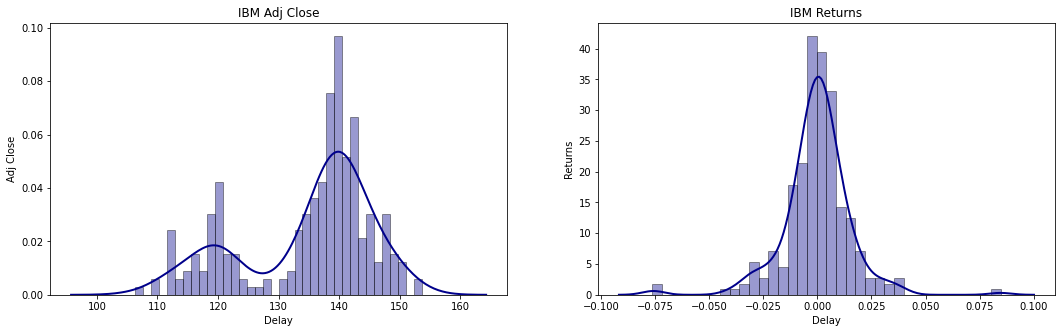

In [478]:
ibmplot = plt.figure(figsize=(18,5))
ibmplot.set_rasterized(True)

ax1 = ibmplot.add_subplot(121)
ax1.set_rasterized(True)
sns.distplot(IBM['Adj Close'], hist=True, kde=True, ax=ax1, bins=int(180/5), color='darkblue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('IBM Adj Close')
plt.xlabel('Delay')
plt.ylabel('Adj Close')

ax2 = ibmplot.add_subplot(122)
ax2.set_rasterized(True)
sns.distplot(IBM['Returns'], hist=True, kde=True, ax=ax2, bins=int(180/5), color='darkblue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('IBM Returns')
plt.xlabel('Delay')
plt.ylabel('Returns')

Text(0, 0.5, 'Returns')

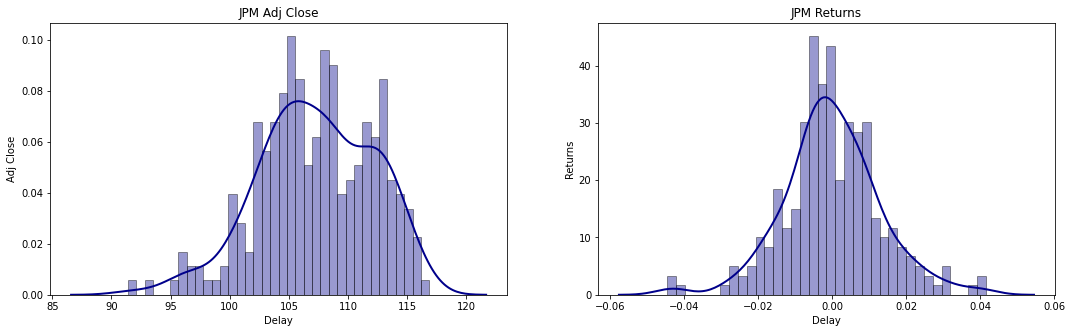

In [479]:
jpmplot = plt.figure(figsize=(18,5))
jpmplot.set_rasterized(True)

ax1 = jpmplot.add_subplot(121)
ax1.set_rasterized(True)
sns.distplot(JPM['Adj Close'], hist=True, kde=True, ax=ax1, bins=int(180/5), color='darkblue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('JPM Adj Close')
plt.xlabel('Delay')
plt.ylabel('Adj Close')

ax2 = jpmplot.add_subplot(122)
ax2.set_rasterized(True)
sns.distplot(JPM['Returns'], hist=True, kde=True, ax=ax2, bins=int(180/5), color='darkblue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('JPM Returns')
plt.xlabel('Delay')
plt.ylabel('Returns')

Text(0, 0.5, 'Returns')

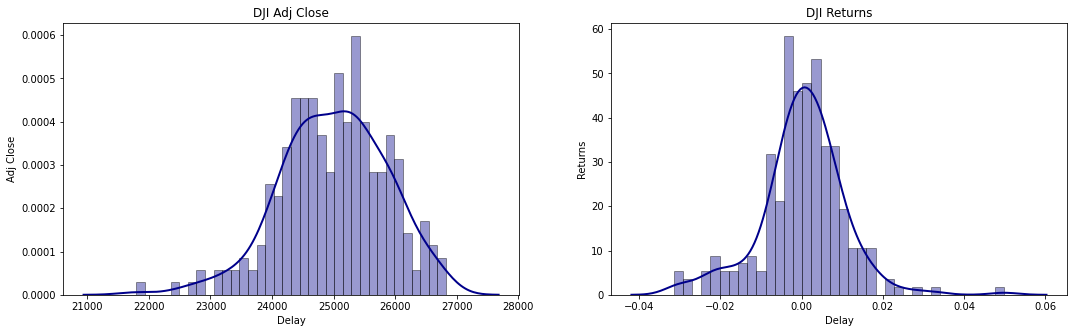

In [480]:
djiplot = plt.figure(figsize=(18,5))
djiplot.set_rasterized(True)

ax1 = djiplot.add_subplot(121)
ax1.set_rasterized(True)
sns.distplot(DJI['Adj Close'], hist=True, kde=True, ax=ax1, bins=int(180/5), color='darkblue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('DJI Adj Close')
plt.xlabel('Delay')
plt.ylabel('Adj Close')

ax2 = djiplot.add_subplot(122)
ax2.set_rasterized(True)
sns.distplot(DJI['Returns'], hist=True, kde=True, ax=ax2, bins=int(180/5), color='darkblue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('DJI Returns')
plt.xlabel('Delay')
plt.ylabel('Returns')

From the figures shown, the adjusted close price of the stocks generally shows an irregular shape. The returns instead, usually perform much more closely to a Gaussian distribution. This means that it might not be a good choice to evaluate the stock prices with their mean and standard deviation data, but those statistics would work well when analysing the returns of stocks.

### (3) Rolling mean and median of adj closes

<AxesSubplot:title={'center':'DJI rolling mean'}, xlabel='Date'>

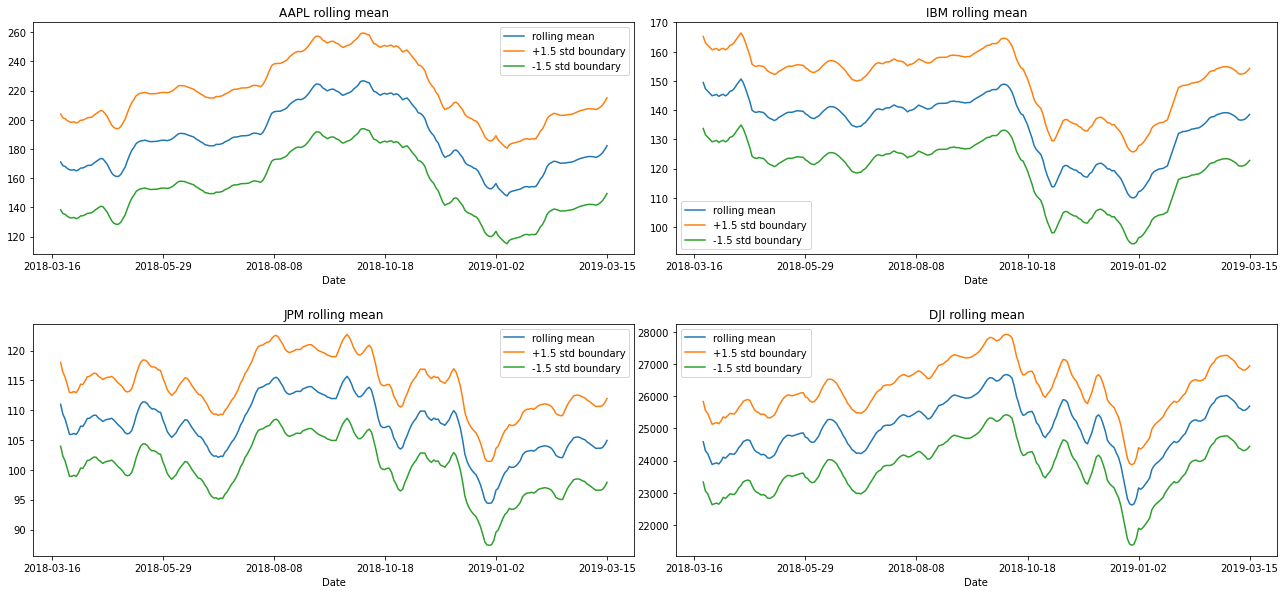

In [525]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

# Rolling means
# AAPL
adj_aapl = AAPL.fillna(value=0, method=None)

aapl_rollingmean = adj_aapl['Adj Close'].rolling(5).mean()
aapl_pos_std = aapl_rollingmean + 1.5 * aapl_rollingmean.std()
aapl_neg_std = aapl_rollingmean - 1.5 * aapl_rollingmean.std()

aapl_rollingmean.plot(grid=True, ax=axes[0,0], title='AAPL rolling mean', legend=True, label='rolling mean')
aapl_pos_std.plot(ax=axes[0,0], legend=True, label='+1.5 std boundary')
aapl_neg_std.plot(ax=axes[0,0], legend=True, label='-1.5 std boundary')


# IBM
adj_ibm = IBM.fillna(value=0, method=None)

ibm_rollingmean = adj_ibm['Adj Close'].rolling(5).mean()
ibm_pos_std = ibm_rollingmean + 1.5 * ibm_rollingmean.std()
ibm_neg_std = ibm_rollingmean - 1.5 * ibm_rollingmean.std()

ibm_rollingmean.plot(grid=True, ax=axes[0,1], title='IBM rolling mean', legend=True, label='rolling mean')
ibm_pos_std.plot(ax=axes[0,1], legend=True, label='+1.5 std boundary')
ibm_neg_std.plot(ax=axes[0,1], legend=True, label='-1.5 std boundary')


# JPM
adj_jpm = JPM.fillna(value=0, method=None)

jpm_rollingmean = adj_jpm['Adj Close'].rolling(5).mean()
jpm_pos_std = jpm_rollingmean + 1.5 * jpm_rollingmean.std()
jpm_neg_std = jpm_rollingmean - 1.5 * jpm_rollingmean.std()

jpm_rollingmean.plot(grid=True, ax=axes[1,0], title='JPM rolling mean', legend=True, label='rolling mean')
jpm_pos_std.plot(ax=axes[1,0], legend=True, label='+1.5 std boundary')
jpm_neg_std.plot(ax=axes[1,0], legend=True, label='-1.5 std boundary')


# DJI
adj_dji = DJI.fillna(value=0, method=None)

dji_rollingmean = adj_dji['Adj Close'].rolling(5).mean()
dji_pos_std = dji_rollingmean + 1.5 * dji_rollingmean.std()
dji_neg_std = dji_rollingmean - 1.5 * dji_rollingmean.std()

dji_rollingmean.plot(grid=True, ax=axes[1,1], title='DJI rolling mean', legend=True, label='rolling mean')
dji_pos_std.plot(ax=axes[1,1], legend=True, label='+1.5 std boundary')
dji_neg_std.plot(ax=axes[1,1], legend=True, label='-1.5 std boundary')

<AxesSubplot:title={'center':'DJI rolling median'}, xlabel='Date'>

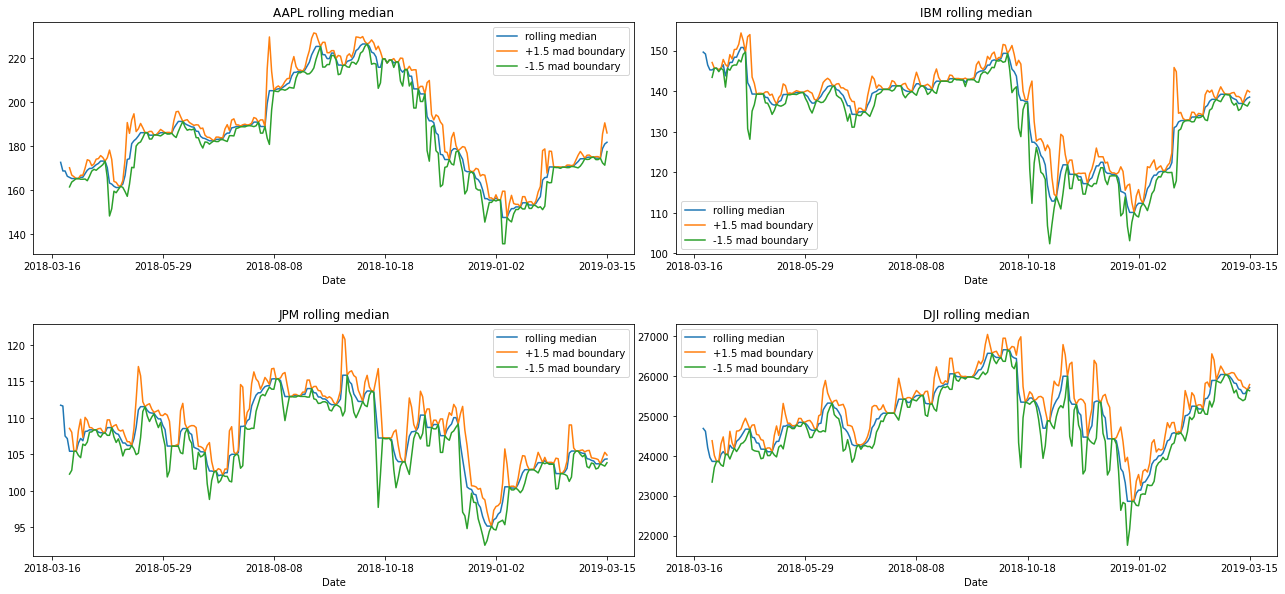

In [536]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

# Rolling medians
# AAPL
aapl_rollingmedian = adj_aapl['Adj Close'].rolling(5).median()
aapl_mad = (abs(aapl_rollingmedian - aapl_rollingmedian.rolling(5).median()))
aapl_pos_mad = aapl_rollingmedian + 1.5 * aapl_mad
aapl_neg_mad = aapl_rollingmedian - 1.5 * aapl_mad

aapl_rollingmedian.plot(grid=True, ax=axes[0,0], title='AAPL rolling median', legend=True, label='rolling median')
aapl_pos_mad.plot(ax=axes[0,0], legend=True, label='+1.5 mad boundary')
aapl_neg_mad.plot(ax=axes[0,0], legend=True, label='-1.5 mad boundary')


# IBM
ibm_rollingmedian = adj_ibm['Adj Close'].rolling(5).median()
ibm_mad = (abs(ibm_rollingmedian - ibm_rollingmedian.rolling(5).median()))
ibm_pos_mad = ibm_rollingmedian + 1.5 * ibm_mad
ibm_neg_mad = ibm_rollingmedian - 1.5 * ibm_mad

ibm_rollingmedian.plot(grid=True, ax=axes[0,1], title='IBM rolling median', legend=True, label='rolling median')
ibm_pos_mad.plot(ax=axes[0,1], legend=True, label='+1.5 mad boundary')
ibm_neg_mad.plot(ax=axes[0,1], legend=True, label='-1.5 mad boundary')


# JPM
jpm_rollingmedian = adj_jpm['Adj Close'].rolling(5).median()
jpm_mad = (abs(jpm_rollingmedian - jpm_rollingmedian.rolling(5).median()))
jpm_pos_mad = jpm_rollingmedian + 1.5 * jpm_mad
jpm_neg_mad = jpm_rollingmedian - 1.5 * jpm_mad

jpm_rollingmedian.plot(grid=True, ax=axes[1,0], title='JPM rolling median', legend=True, label='rolling median')
jpm_pos_mad.plot(ax=axes[1,0], legend=True, label='+1.5 mad boundary')
jpm_neg_mad.plot(ax=axes[1,0], legend=True, label='-1.5 mad boundary')


# DJI
dji_rollingmedian = adj_dji['Adj Close'].rolling(5).median()
dji_mad = (abs(dji_rollingmedian - dji_rollingmedian.rolling(5).median()))
dji_pos_mad = dji_rollingmedian + 1.5 * dji_mad
dji_neg_mad = dji_rollingmedian - 1.5 * dji_mad

dji_rollingmedian.plot(grid=True, ax=axes[1,1], title='DJI rolling median', legend=True, label='rolling median')
dji_pos_mad.plot(ax=axes[1,1], legend=True, label='+1.5 mad boundary')
dji_neg_mad.plot(ax=axes[1,1], legend=True, label='-1.5 mad boundary')


### (4) Outliers in adj close

In [552]:
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']
adjc_aapl = AAPL['Adj Close'].fillna(value=0, method=None)
adjc_ibm = IBM['Adj Close'].fillna(value=0, method=None)
adjc_jpm = JPM['Adj Close'].fillna(value=0, method=None)
adjc_dji = DJI['Adj Close'].fillna(value=0, method=None)

aapl_out = 1.2 * adjc_aapl.max()
ibm_out = 1.2 * adjc_ibm.max()
jpm_out = 1.2 * adjc_jpm.max()
dji_out = 1.2 * adjc_dji.max()

# Append outliers
for date in dates:
    adjc_aapl[date] = aapl_out
    adjc_ibm[date] = ibm_out
    adjc_jpm[date] = jpm_out
    adjc_dji[date] = dji_out

<AxesSubplot:title={'center':'DJI rolling mean with outliers'}, xlabel='Date'>

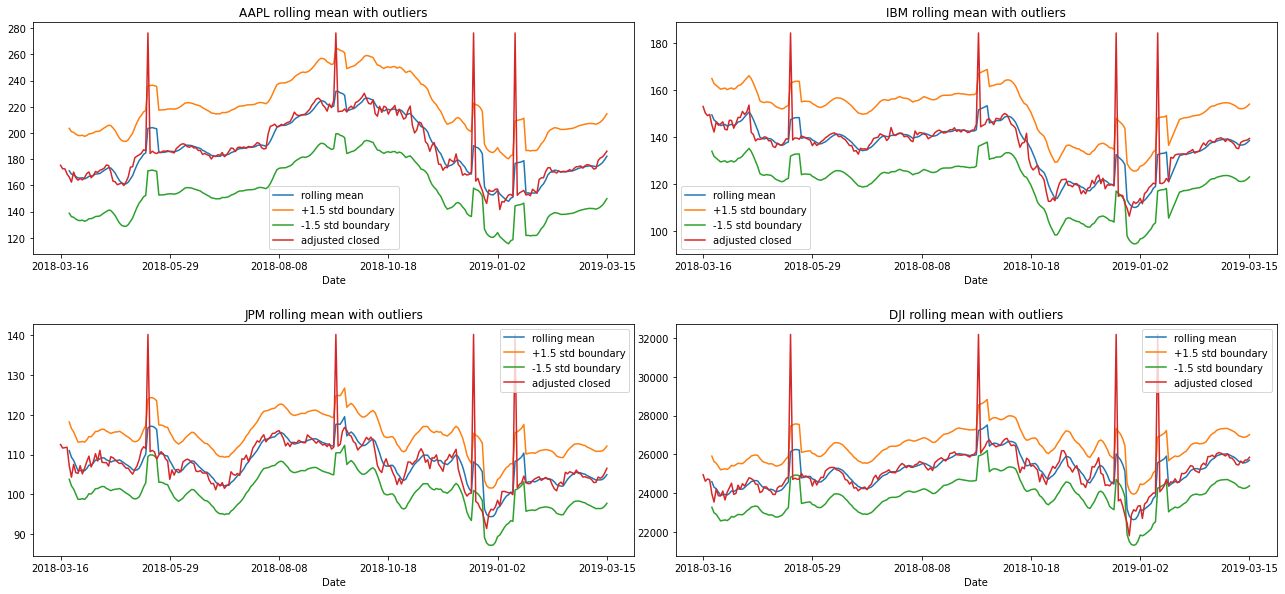

In [554]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

# Rolling means with outliers
# AAPL
aapl_rollingmean = adjc_aapl.rolling(5).mean()
aapl_pos_std = aapl_rollingmean + 1.5 * aapl_rollingmean.std()
aapl_neg_std = aapl_rollingmean - 1.5 * aapl_rollingmean.std()

aapl_rollingmean.plot(grid=True, ax=axes[0,0], title='AAPL rolling mean with outliers', legend=True, label='rolling mean')
aapl_pos_std.plot(ax=axes[0,0], legend=True, label='+1.5 std boundary')
aapl_neg_std.plot(ax=axes[0,0], legend=True, label='-1.5 std boundary')
adjc_aapl.plot(ax=axes[0,0], legend=True, label='adjusted closed')


# IBM
ibm_rollingmean = adjc_ibm.rolling(5).mean()
ibm_pos_std = ibm_rollingmean + 1.5 * ibm_rollingmean.std()
ibm_neg_std = ibm_rollingmean - 1.5 * ibm_rollingmean.std()

ibm_rollingmean.plot(grid=True, ax=axes[0,1], title='IBM rolling mean with outliers', legend=True, label='rolling mean')
ibm_pos_std.plot(ax=axes[0,1], legend=True, label='+1.5 std boundary')
ibm_neg_std.plot(ax=axes[0,1], legend=True, label='-1.5 std boundary')
adjc_ibm.plot(ax=axes[0,1], legend=True, label='adjusted closed')


# JPM
jpm_rollingmean = adjc_jpm.rolling(5).mean()
jpm_pos_std = jpm_rollingmean + 1.5 * jpm_rollingmean.std()
jpm_neg_std = jpm_rollingmean - 1.5 * jpm_rollingmean.std()

jpm_rollingmean.plot(grid=True, ax=axes[1,0], title='JPM rolling mean with outliers', legend=True, label='rolling mean')
jpm_pos_std.plot(ax=axes[1,0], legend=True, label='+1.5 std boundary')
jpm_neg_std.plot(ax=axes[1,0], legend=True, label='-1.5 std boundary')
adjc_jpm.plot(ax=axes[1,0], legend=True, label='adjusted closed')


# DJI
dji_rollingmean = adjc_dji.rolling(5).mean()
dji_pos_std = dji_rollingmean + 1.5 * dji_rollingmean.std()
dji_neg_std = dji_rollingmean - 1.5 * dji_rollingmean.std()

dji_rollingmean.plot(grid=True, ax=axes[1,1], title='DJI rolling mean with outliers', legend=True, label='rolling mean')
dji_pos_std.plot(ax=axes[1,1], legend=True, label='+1.5 std boundary')
dji_neg_std.plot(ax=axes[1,1], legend=True, label='-1.5 std boundary')
adjc_dji.plot(ax=axes[1,1], legend=True, label='adjusted closed')

<AxesSubplot:title={'center':'DJI rolling median with outliers'}, xlabel='Date'>

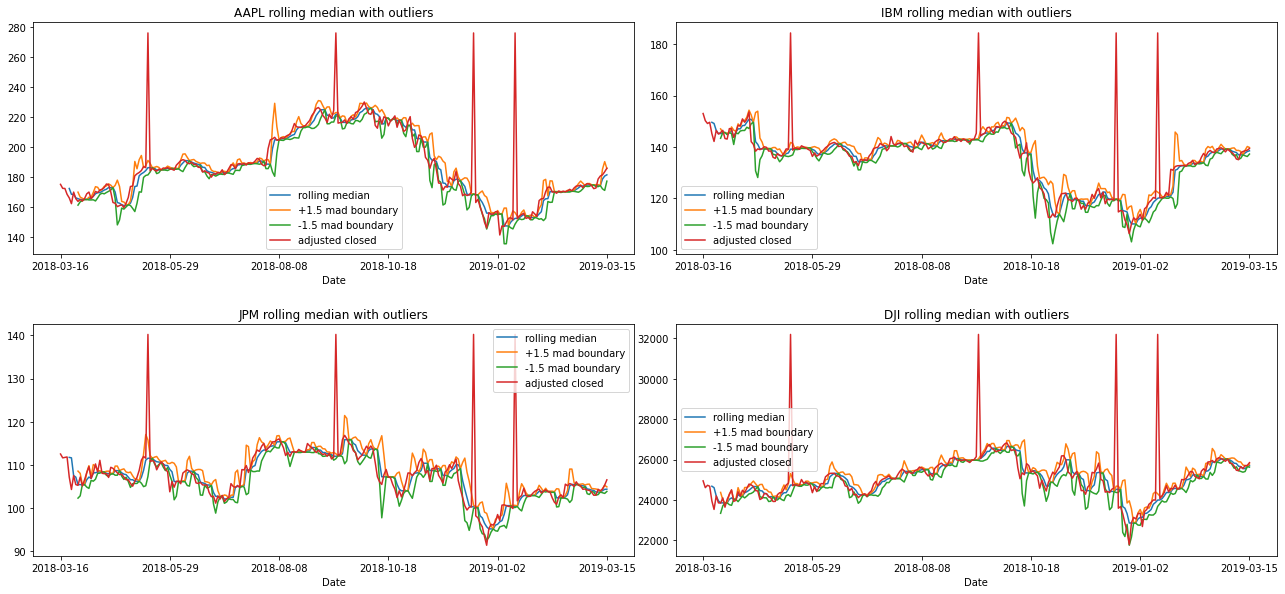

In [555]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

# Rolling medians
# AAPL
aapl_rollingmedian = adjc_aapl.rolling(5).median()
aapl_mad = (abs(aapl_rollingmedian - aapl_rollingmedian.rolling(5).median()))
aapl_pos_mad = aapl_rollingmedian + 1.5 * aapl_mad
aapl_neg_mad = aapl_rollingmedian - 1.5 * aapl_mad

aapl_rollingmedian.plot(grid=True, ax=axes[0,0], title='AAPL rolling median with outliers', legend=True, label='rolling median')
aapl_pos_mad.plot(ax=axes[0,0], legend=True, label='+1.5 mad boundary')
aapl_neg_mad.plot(ax=axes[0,0], legend=True, label='-1.5 mad boundary')
adjc_aapl.plot(ax=axes[0,0], legend=True, label='adjusted closed')


# IBM
ibm_rollingmedian = adjc_ibm.rolling(5).median()
ibm_mad = (abs(ibm_rollingmedian - ibm_rollingmedian.rolling(5).median()))
ibm_pos_mad = ibm_rollingmedian + 1.5 * ibm_mad
ibm_neg_mad = ibm_rollingmedian - 1.5 * ibm_mad

ibm_rollingmedian.plot(grid=True, ax=axes[0,1], title='IBM rolling median with outliers', legend=True, label='rolling median')
ibm_pos_mad.plot(ax=axes[0,1], legend=True, label='+1.5 mad boundary')
ibm_neg_mad.plot(ax=axes[0,1], legend=True, label='-1.5 mad boundary')
adjc_ibm.plot(ax=axes[0,1], legend=True, label='adjusted closed')


# JPM
jpm_rollingmedian = adjc_jpm.rolling(5).median()
jpm_mad = (abs(jpm_rollingmedian - jpm_rollingmedian.rolling(5).median()))
jpm_pos_mad = jpm_rollingmedian + 1.5 * jpm_mad
jpm_neg_mad = jpm_rollingmedian - 1.5 * jpm_mad

jpm_rollingmedian.plot(grid=True, ax=axes[1,0], title='JPM rolling median with outliers', legend=True, label='rolling median')
jpm_pos_mad.plot(ax=axes[1,0], legend=True, label='+1.5 mad boundary')
jpm_neg_mad.plot(ax=axes[1,0], legend=True, label='-1.5 mad boundary')
adjc_jpm.plot(ax=axes[1,0], legend=True, label='adjusted closed')


# DJI
dji_rollingmedian = adjc_dji.rolling(5).median()
dji_mad = (abs(dji_rollingmedian - dji_rollingmedian.rolling(5).median()))
dji_pos_mad = dji_rollingmedian + 1.5 * dji_mad
dji_neg_mad = dji_rollingmedian - 1.5 * dji_mad

dji_rollingmedian.plot(grid=True, ax=axes[1,1], title='DJI rolling median with outliers', legend=True, label='rolling median')
dji_pos_mad.plot(ax=axes[1,1], legend=True, label='+1.5 mad boundary')
dji_neg_mad.plot(ax=axes[1,1], legend=True, label='-1.5 mad boundary')
adjc_dji.plot(ax=axes[1,1], legend=True, label='adjusted closed')

From the plots shown, the outliers have a huge impact on the results of rolling mean and their standard deviations. In contrast, rolling medians and the median absolute deviations are not affected too much by outliers, where can be recognized as a more reliable method which is more robust to any anomalous situation.

### (5) Box plots of adj close

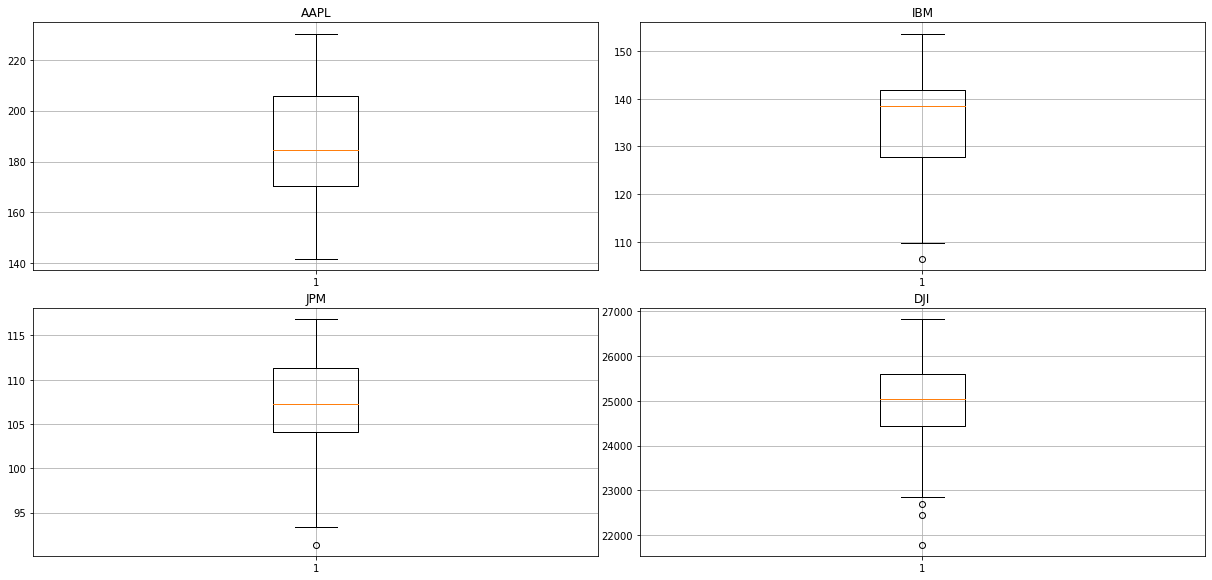

In [582]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# AAPL
adj_aapl = AAPL['Adj Close'].fillna(value=0, method=None)
ax0 = axes[0,0]
ax0.boxplot(adj_aapl)
ax0.set_title('AAPL')
ax0.grid()

# IBM
adj_ibm = IBM['Adj Close'].fillna(value=0, method=None)
ax1 = axes[0,1]
ax1.boxplot(adj_ibm)
ax1.set_title('IBM')
ax1.grid()

# JPM
adj_jpm = JPM['Adj Close'].fillna(value=0, method=None)
ax2 = axes[1,0]
ax2.boxplot(adj_jpm)
ax2.set_title('JPM')
ax2.grid()

# DJI
adj_dji = DJI['Adj Close'].fillna(value=0, method=None)
ax3 = axes[1,1]
ax3.boxplot(adj_dji)
ax3.set_title('DJI')
ax3.grid()

The box plots show how how dispersive the data-set is for the stocks. The orange lines refer to their median points respectively  and the upper and lower box lines (in the square shape) gives the 75% and 25% quartile bounds. The upper and lower end of the box plot represent the upper and lower range of data. Circles shows where outliers are. From the figures, the adjusted close prices data are quite asymptotic like what were shown before in the histograms in part (2), it therefore reaffirms that using mean and standard deviation (or the Gaussian distribution) may not be a good way to analyse the return data.

## 4.2  Robust Estimators

### (1) Set up estimators

In [592]:
#from scipy.stats import iqr

def median_est(data):
    # sort the values with their magnitudes
    order = data.sort_values()
    if ((len(data)) % 2) == 0:
        position = len(data)/2
    else:
        position = (len(data)+1)/2
    median = data[round(position)]
    return median

def IQR(data):
    # sort the values with their magnitudes
    order = data.sort_values()
    # find upper and lower quartile positions
    upbound = data[round(len(data)*0.25)]
    lowbound = data[round(len(data)*0.75)]
    iqr_range = upbound - lowbound
    return iqr_range

def MAD(data):
    med = median_est(data)
    mad = np.median(abs(data - med))
    return mad

In [593]:
print('AAPL adj close price has median: ', median_est(adj_aapl), ' with interquartile range: ', IQR(adj_aapl), ' and its median absolute deviation is: ', MAD(adj_aapl))
print('IBM adj close price has median: ', median_est(adj_ibm), ' with interquartile range: ', IQR(adj_ibm), ' and its median absolute deviation is: ', MAD(adj_ibm))
print('JPM adj close price has median: ', median_est(adj_jpm), ' with interquartile range: ', IQR(adj_jpm), ' and its median absolute deviation is: ', MAD(adj_jpm))
print('DJI adj close price has median: ', median_est(adj_dji), ' with interquartile range: ', IQR(adj_dji), ' and its median absolute deviation is: ', MAD(adj_dji))

AAPL adj close price has median:  222.1091  with interquartile range:  16.504929000000004  and its median absolute deviation is:  37.75732400000001
IBM adj close price has median:  144.77774  with interquartile range:  21.051834  and its median absolute deviation is:  6.221023000000002
JPM adj close price has median:  111.802765  with interquartile range:  5.406616  and its median absolute deviation is:  4.60629999999999
DJI adj close price has median:  26154.669922  with interquartile range:  493.0996099999975  and its median absolute deviation is:  1110.3808590000008


### (2) Computational efficiency

All the estimators including the median, IQR and MAD have to sort before calculations. The sort function *sort_values* has the time complexity of $O(nlog(n))$. After sorting, median and IQR estimators only need to go through their function once and they both have complexity of $O(1)$. <br/><br/>
However, for MAD, as it needs to calculate the median of the absolute differences between a particular data and the median of the series, it has to go through the whole series and therefore will have the time complexity of $O(n)$, where n refers to the length of the series.

### (3) Break points

The breakdown point is the point which an estimator will become useless after that point. It measures the robustness of a certain estimator. The median has a breakdown point of 50% and the interquartile range has a breakdown point of 25%. <br/><br/>
Therefore, median will only vary a bit unless extra 50% of the data has been added or edited. The interquarile range is relatively less robust and will become useless when 25% of its data has been changed. The median absolute deviation should share the same robustness as the median.<br/><br/>
All the statistics above including median, IQR and MAD are more robust to outliers compared with the mean, which has a breakdown point of $\frac{1}{N}$.

## 4.3  Robust and OLS regression

### (1)  OLS regression

In [643]:
dji_ret = DJI['Returns'].fillna(value=0, method=None)

appl_ret = AAPL['Returns'].fillna(value=0, method=None)
ibm_ret = IBM['Returns'].fillna(value=0, method=None)
jpm_ret = JPM['Returns'].fillna(value=0, method=None)

Text(0.5, 1.0, 'JPM')

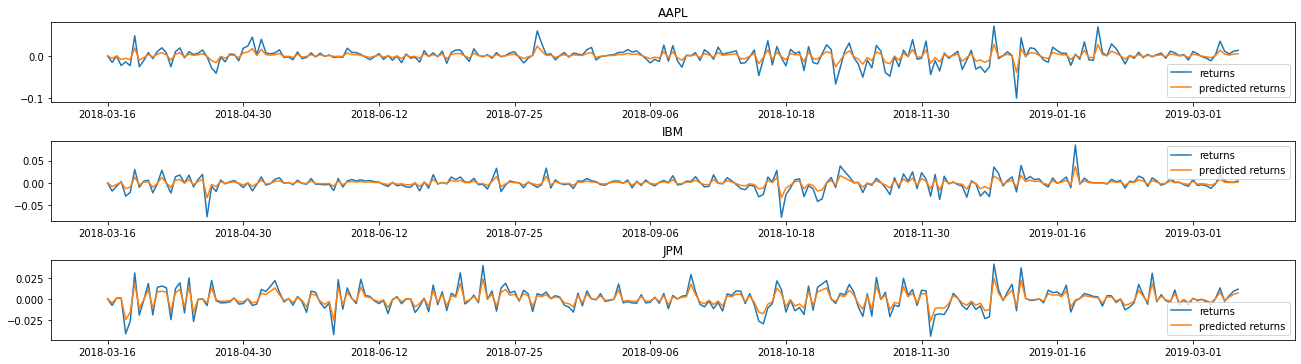

In [639]:
import statsmodels.api as sm
import matplotlib.ticker as ticker
from statsmodels.sandbox.regression.predstd import wls_prediction_std

fig, axs = plt.subplots(3,1, figsize=(18,5))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)

# APPL
tick_spacing = 30
appl_ols = sm.OLS(dji_ret, appl_ret).fit()
appl_pre = appl_ols.predict()
ax0 = axs[0]
ax0.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax0.plot(appl_ret.index, appl_ret, label='returns')
ax0.plot(appl_ret.index, appl_pre, label='predicted returns')
ax0.legend()
ax0.set_title('AAPL')

# IBM
ibm_ols = sm.OLS(dji_ret, ibm_ret).fit()
ibm_pre = ibm_ols.predict()
ax1 = axs[1]
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.plot(ibm_ret.index, ibm_ret, label='returns')
ax1.plot(ibm_ret.index, ibm_pre, label='predicted returns')
ax1.legend()
ax1.set_title('IBM')

# JPM
jpm_ols = sm.OLS(dji_ret, jpm_ret).fit()
jpm_pre = jpm_ols.predict()
ax2 = axs[2]
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.plot(jpm_ret.index, jpm_ret, label='returns')
ax2.plot(jpm_ret.index, jpm_pre, label='predicted returns')
ax2.legend()
ax2.set_title('JPM')

In [640]:
print('APPL R2 value: ', appl_ols.rsquared)
print('IBM R2 value: ', ibm_ols.rsquared)
print('JPM R2 value: ', jpm_ols.rsquared)

APPL R2 value:  0.5166800876709028
IBM R2 value:  0.4171211230009393
JPM R2 value:  0.5553236460004664


### (2) Huber regression

In [646]:
from sklearn.linear_model import HuberRegressor, LinearRegression

djihu_ret = np.array(dji_ret).reshape(-1,1)
applhu_ret = np.array(appl_ret).reshape(-1,1)
ibmhu_ret = np.array(ibm_ret).reshape(-1,1)
jpmhu_ret = np.array(jpm_ret).reshape(-1,1)

Text(0.5, 1.0, 'JPM')

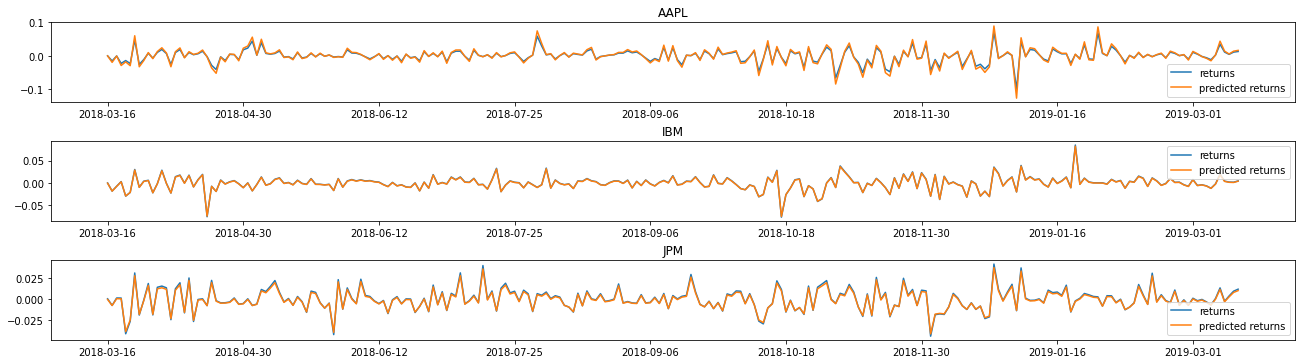

In [649]:
fig, axs = plt.subplots(3,1, figsize=(18,5))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)


# APPL
tick_spacing = 30
appl_huber = HuberRegressor().fit(djihu_ret, applhu_ret)
appl_prehu = appl_huber.predict(applhu_ret)
ax0 = axs[0]
ax0.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax0.plot(appl_ret.index, applhu_ret, label='returns')
ax0.plot(appl_ret.index, appl_prehu, label='predicted returns')
ax0.legend()
ax0.set_title('AAPL')

# IBM
ibm_huber = HuberRegressor().fit(djihu_ret, ibmhu_ret)
ibm_prehu = ibm_huber.predict(ibmhu_ret)
ax1 = axs[1]
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.plot(ibm_ret.index, ibmhu_ret, label='returns')
ax1.plot(ibm_ret.index, ibm_prehu, label='predicted returns')
ax1.legend()
ax1.set_title('IBM')

# JPM
jpm_huber = HuberRegressor().fit(djihu_ret, jpmhu_ret)
jpm_prehu = jpm_huber.predict(jpmhu_ret)
ax2 = axs[2]
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.plot(jpm_ret.index, jpmhu_ret, label='returns')
ax2.plot(jpm_ret.index, jpm_prehu, label='predicted returns')
ax2.legend()
ax2.set_title('JPM')

In [653]:
print('APPL R2 value: ', appl_huber.score(applhu_ret, appl_ret, sample_weight=None))
print('IBM R2 value: ', ibm_huber.score(ibmhu_ret, ibm_ret, sample_weight=None))
print('JPM R2 value: ', jpm_huber.score(jpmhu_ret, jpm_ret, sample_weight=None))

APPL R2 value:  0.9268953698340756
IBM R2 value:  0.9982617918714101
JPM R2 value:  0.9898915937226312


### (3) Outliers impact

In [654]:
# Set up outliers like before
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']
ret_aapl = AAPL['Returns'].fillna(value=0, method=None)
ret_ibm = IBM['Returns'].fillna(value=0, method=None)
ret_jpm = JPM['Returns'].fillna(value=0, method=None)
ret_dji = DJI['Returns'].fillna(value=0, method=None)

aapl_outr = 1.2 * adjc_aapl.max()
ibm_outr = 1.2 * adjc_ibm.max()
jpm_outr = 1.2 * adjc_jpm.max()
dji_outr = 1.2 * adjc_dji.max()

# Append outliers
for date in dates:
    ret_aapl[date] = aapl_outr
    ret_ibm[date] = ibm_outr
    ret_jpm[date] = jpm_outr
    ret_dji[date] = dji_outr

djiout_ret = np.array(ret_aapl).reshape(-1,1)
applout_ret = np.array(ret_ibm).reshape(-1,1)
ibmout_ret = np.array(ret_jpm).reshape(-1,1)
jpmout_ret = np.array(ret_dji).reshape(-1,1)

Text(0.5, 1.0, 'JPM')

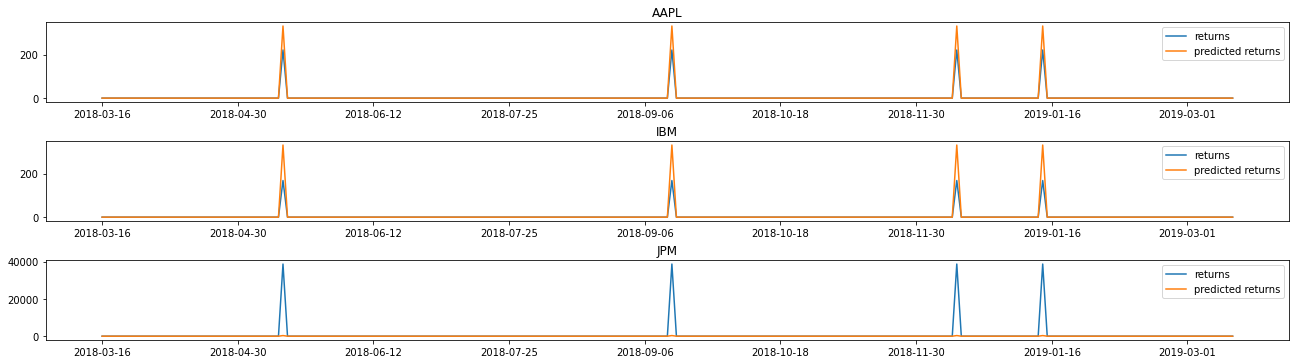

In [655]:
####### OLS #######
fig, axs = plt.subplots(3,1, figsize=(18,5))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)

# APPL
tick_spacing = 30
appl_ols = sm.OLS(djiout_ret, applout_ret).fit()
appl_pre = appl_ols.predict()
ax0 = axs[0]
ax0.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax0.plot(appl_ret.index, applout_ret, label='returns')
ax0.plot(appl_ret.index, appl_pre, label='predicted returns')
ax0.legend()
ax0.set_title('AAPL')

# IBM
ibm_ols = sm.OLS(djiout_ret, ibmout_ret).fit()
ibm_pre = ibm_ols.predict()
ax1 = axs[1]
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.plot(ibm_ret.index, ibmout_ret, label='returns')
ax1.plot(ibm_ret.index, ibm_pre, label='predicted returns')
ax1.legend()
ax1.set_title('IBM')

# JPM
jpm_ols = sm.OLS(djiout_ret, jpmout_ret).fit()
jpm_pre = jpm_ols.predict()
ax2 = axs[2]
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.plot(jpm_ret.index, jpmout_ret, label='returns')
ax2.plot(jpm_ret.index, jpm_pre, label='predicted returns')
ax2.legend()
ax2.set_title('JPM')

In [656]:
print('APPL R2 value: ', appl_ols.rsquared)
print('IBM R2 value: ', ibm_ols.rsquared)
print('JPM R2 value: ', jpm_ols.rsquared)

APPL R2 value:  0.9999997130873519
IBM R2 value:  0.9999996813251955
JPM R2 value:  0.9999997930451299


Text(0.5, 1.0, 'JPM')

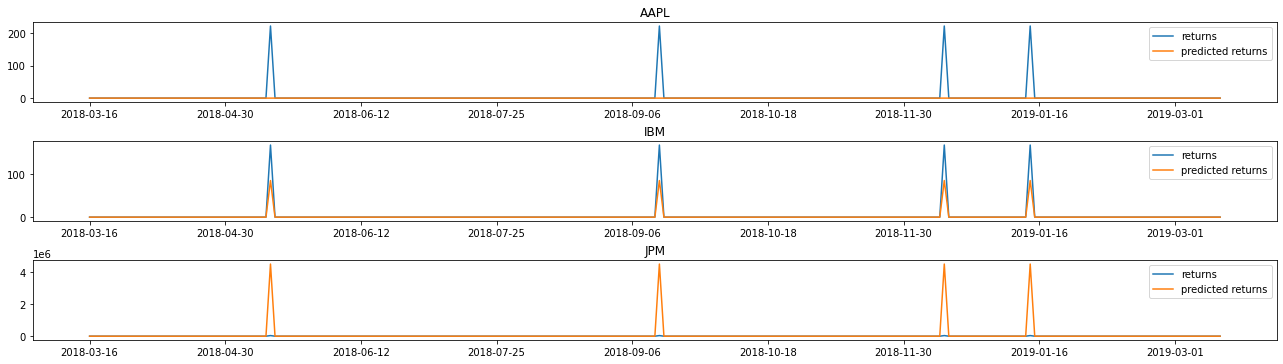

In [657]:
####### Huber #######
fig, axs = plt.subplots(3,1, figsize=(18,5))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)


# APPL
tick_spacing = 30
appl_huber = HuberRegressor().fit(djiout_ret, applout_ret)
appl_prehu = appl_huber.predict(applhu_ret)
ax0 = axs[0]
ax0.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax0.plot(appl_ret.index, applout_ret, label='returns')
ax0.plot(appl_ret.index, appl_prehu, label='predicted returns')
ax0.legend()
ax0.set_title('AAPL')

# IBM
ibm_huber = HuberRegressor().fit(djiout_ret, ibmout_ret)
ibm_prehu = ibm_huber.predict(ibmout_ret)
ax1 = axs[1]
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.plot(ibm_ret.index, ibmout_ret, label='returns')
ax1.plot(ibm_ret.index, ibm_prehu, label='predicted returns')
ax1.legend()
ax1.set_title('IBM')

# JPM
jpm_huber = HuberRegressor().fit(djiout_ret, jpmout_ret)
jpm_prehu = jpm_huber.predict(jpmout_ret)
ax2 = axs[2]
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.plot(jpm_ret.index, jpmout_ret, label='returns')
ax2.plot(jpm_ret.index, jpm_prehu, label='predicted returns')
ax2.legend()
ax2.set_title('JPM')

In [658]:
print('APPL R2 value: ', appl_huber.score(applhu_ret, applout_ret, sample_weight=None))
print('IBM R2 value: ', ibm_huber.score(ibmhu_ret, ibmout_ret, sample_weight=None))
print('JPM R2 value: ', jpm_huber.score(jpmhu_ret, jpmout_ret, sample_weight=None))

APPL R2 value:  -0.016288764883420015
IBM R2 value:  -0.016232792373743976
JPM R2 value:  -0.01619913385745564


## 4.4 Robust Trading Strategies

### (1) Moving average crossover

In [659]:
adj_aapl = AAPL['Adj Close'].fillna(value=0, method=None)
adj_ibm = IBM['Adj Close'].fillna(value=0, method=None)
adj_jpm = JPM['Adj Close'].fillna(value=0, method=None)
adj_dji = DJI['Adj Close'].fillna(value=0, method=None)

#adjc_aapl 
#adjc_ibm 
#adjc_jpm 
#adjc_dji

In [723]:
# Moving average crossover 
aapl_ma20 = adj_aapl.rolling(20).mean()
aapl_ma50 = adj_aapl.rolling(50).mean()

# with outliers
aaplout_ma20 = adjc_aapl.rolling(20).mean()
aaplout_ma50 = adjc_aapl.rolling(50).mean()

# Set up buy and sell rules
aapl_buysell0 = (aapl_ma20 - aapl_ma50).dropna()
aapl_buysell_out0 = (aaplout_ma20 - aaplout_ma50).dropna()

In [724]:
aapl_buysell = np.sign(aapl_buysell0)*10
aapl_buysell_out = np.sign(aapl_buysell_out0)*10

In [727]:
aapl_cum = np.cumsum(AAPL['Returns']*aapl_buysell)
aaplout_cum = np.cumsum(AAPL['Returns']*aapl_buysell_out)

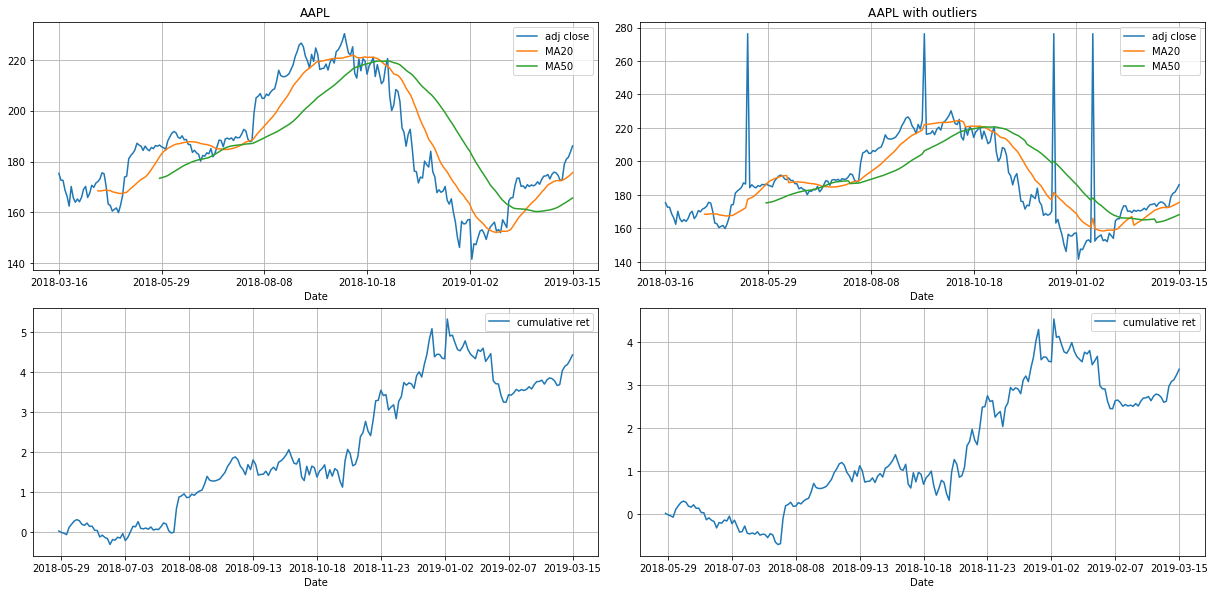

In [728]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

#fig, axs = plt.subplots(2,1, figsize=(18,5))
#fig.tight_layout()
#fig.subplots_adjust(hspace=0.5)

# AAPL
ax0 = axes[0,0]
#ax0 = axs[0]
adj_aapl.plot(ax=ax0, label='adj close')
aapl_ma20.plot(ax=ax0, label='MA20')
aapl_ma50.plot(ax=ax0, label='MA50')
ax0.set_title('AAPL')
ax0.legend()
ax0.grid()

ax1 = axes[1,0]
aapl_cum.plot(ax=ax1, label='cumulative ret')
ax1.legend()
ax1.grid()

# with outliers
ax2 = axes[0,1]
#ax2=axs[1]
adjc_aapl.plot(ax=ax2, label='adj close')
aaplout_ma20.plot(ax=ax2, label='MA20')
aaplout_ma50.plot(ax=ax2, label='MA50')
ax2.set_title('AAPL with outliers')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
aaplout_cum.plot(ax=ax3, label='cumulative ret')
ax3.legend()
ax3.grid()

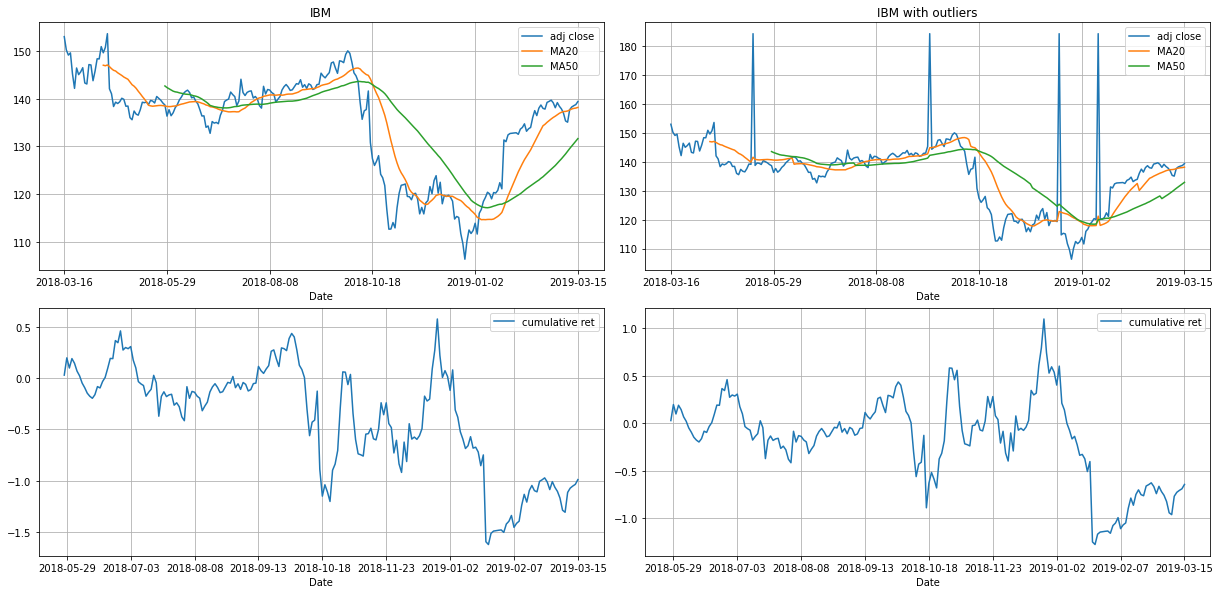

In [695]:
# Moving average crossover 
ibm_ma20 = adj_ibm.rolling(20).mean()
ibm_ma50 = adj_ibm.rolling(50).mean()

# with outliers
ibmout_ma20 = adjc_ibm.rolling(20).mean()
ibmout_ma50 = adjc_ibm.rolling(50).mean()

# Set up buy and sell rules
ibm_buysell0 = (ibm_ma20 - ibm_ma50).dropna()
ibm_buysell_out0 = (ibmout_ma20 - ibmout_ma50).dropna()

ibm_buysell = np.sign(ibm_buysell0)*10
ibm_buysell_out = np.sign(ibm_buysell_out0)*10

ibm_cum = np.cumsum(IBM['Returns']*ibm_buysell)
ibmout_cum = np.cumsum(IBM['Returns']*ibm_buysell_out)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# IBM
ax0 = axes[0,0]
adj_ibm.plot(ax=ax0, label='adj close')
ibm_ma20.plot(ax=ax0, label='MA20')
ibm_ma50.plot(ax=ax0, label='MA50')
ax0.set_title('IBM')
ax0.legend()
ax0.grid()

ax1 = axes[1,0]
ibm_cum.plot(ax=ax1, label='cumulative ret')
ax1.legend()
ax1.grid()

# with outliers
ax2 = axes[0,1]
adjc_ibm.plot(ax=ax2, label='adj close')
ibmout_ma20.plot(ax=ax2, label='MA20')
ibmout_ma50.plot(ax=ax2, label='MA50')
ax2.set_title('IBM with outliers')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
ibmout_cum.plot(ax=ax3, label='cumulative ret')
ax3.legend()
ax3.grid()

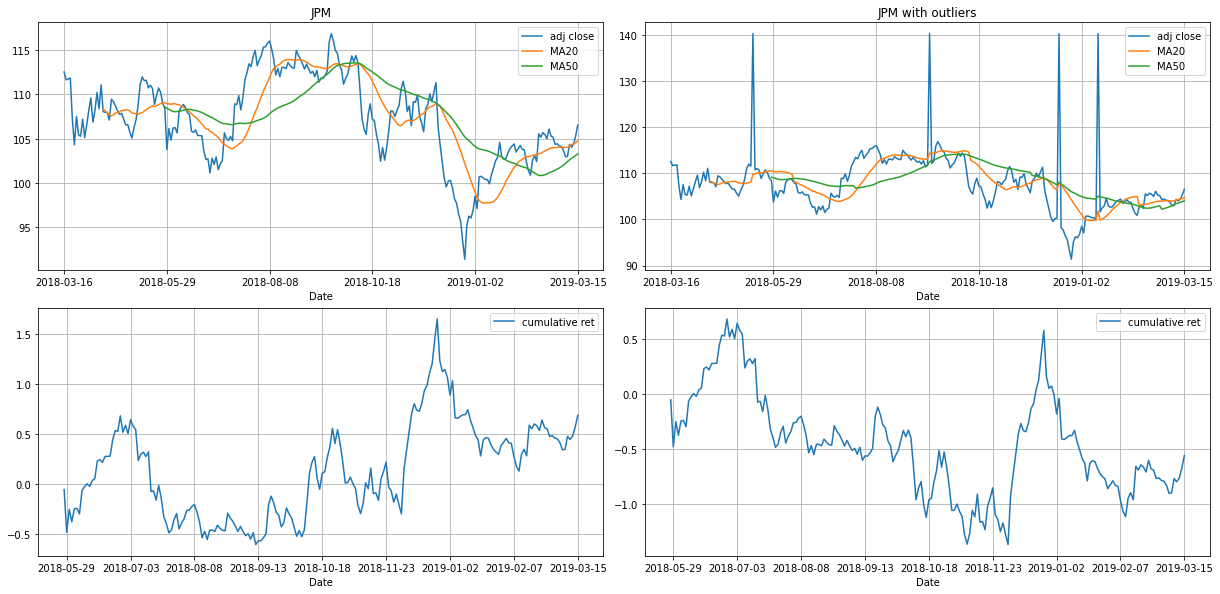

In [717]:
# Moving average crossover 
jpm_ma20 = adj_jpm.rolling(20).mean()
jpm_ma50 = adj_jpm.rolling(50).mean()

# with outliers
jpmout_ma20 = adjc_jpm.rolling(20).mean()
jpmout_ma50 = adjc_jpm.rolling(50).mean()

# Set up buy and sell rules
jpm_buysell0 = (jpm_ma20 - jpm_ma50).dropna()
jpm_buysell_out0 = (jpmout_ma20 - jpmout_ma50).dropna()

jpm_buysell = np.sign(jpm_buysell0)*10
jpm_buysell_out = np.sign(jpm_buysell_out0)*10

jpm_cum = np.cumsum(JPM['Returns']*jpm_buysell)
jpmout_cum = np.cumsum(JPM['Returns']*jpm_buysell_out)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# JPM
ax0 = axes[0,0]
adj_jpm.plot(ax=ax0, label='adj close')
jpm_ma20.plot(ax=ax0, label='MA20')
jpm_ma50.plot(ax=ax0, label='MA50')
ax0.set_title('JPM')
ax0.legend()
ax0.grid()

ax1 = axes[1,0]
jpm_cum.plot(ax=ax1, label='cumulative ret')
ax1.legend()
ax1.grid()

# with outliers
ax2 = axes[0,1]
adjc_jpm.plot(ax=ax2, label='adj close')
jpmout_ma20.plot(ax=ax2, label='MA20')
jpmout_ma50.plot(ax=ax2, label='MA50')
ax2.set_title('JPM with outliers')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
jpmout_cum.plot(ax=ax3, label='cumulative ret')
ax3.legend()
ax3.grid()

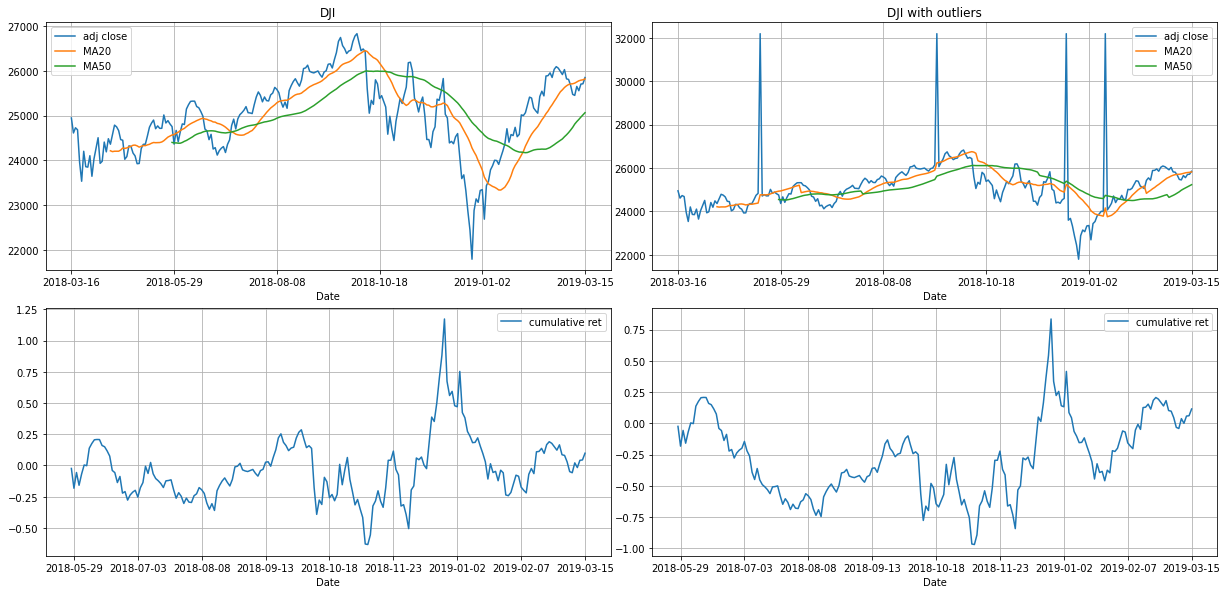

In [718]:
# Moving average crossover 
dji_ma20 = adj_dji.rolling(20).mean()
dji_ma50 = adj_dji.rolling(50).mean()

# with outliers
djiout_ma20 = adjc_dji.rolling(20).mean()
djiout_ma50 = adjc_dji.rolling(50).mean()

# Set up buy and sell rules
dji_buysell0 = (dji_ma20 - dji_ma50).dropna()
dji_buysell_out0 = (djiout_ma20 - djiout_ma50).dropna()

dji_buysell = np.sign(dji_buysell0)*10
dji_buysell_out = np.sign(dji_buysell_out0)*10

dji_cum = np.cumsum(DJI['Returns']*dji_buysell)
djiout_cum = np.cumsum(DJI['Returns']*dji_buysell_out)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# DJI
ax0 = axes[0,0]
adj_dji.plot(ax=ax0, label='adj close')
dji_ma20.plot(ax=ax0, label='MA20')
dji_ma50.plot(ax=ax0, label='MA50')
ax0.set_title('DJI')
ax0.legend()
ax0.grid()

ax1 = axes[1,0]
dji_cum.plot(ax=ax1, label='cumulative ret')
ax1.legend()
ax1.grid()

# with outliers
ax2 = axes[0,1]
adjc_dji.plot(ax=ax2, label='adj close')
djiout_ma20.plot(ax=ax2, label='MA20')
djiout_ma50.plot(ax=ax2, label='MA50')
ax2.set_title('DJI with outliers')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
djiout_cum.plot(ax=ax3, label='cumulative ret')
ax3.legend()
ax3.grid()

## (2) Rolling median crossover

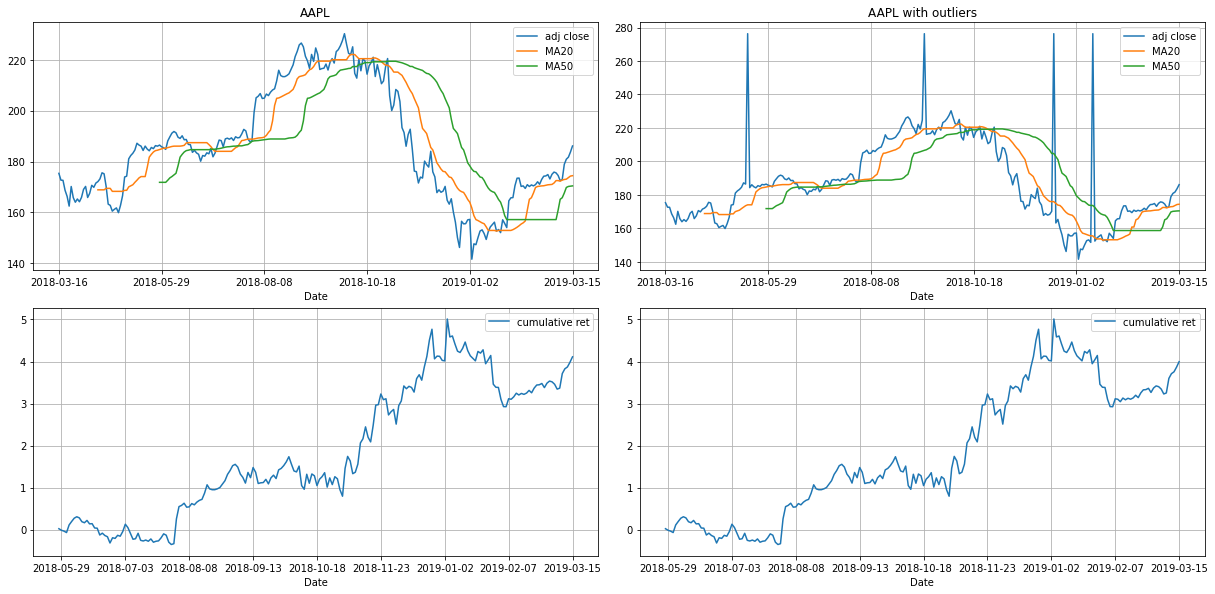

In [729]:
# Moving average crossover 
aapl_ma20 = adj_aapl.rolling(20).median()
aapl_ma50 = adj_aapl.rolling(50).median()

# with outliers
aaplout_ma20 = adjc_aapl.rolling(20).median()
aaplout_ma50 = adjc_aapl.rolling(50).median()

# Set up buy and sell rules
aapl_buysell0 = (aapl_ma20 - aapl_ma50).dropna()
aapl_buysell_out0 = (aaplout_ma20 - aaplout_ma50).dropna()

aapl_buysell = np.sign(aapl_buysell0)*10
aapl_buysell_out = np.sign(aapl_buysell_out0)*10

aapl_cum = np.cumsum(AAPL['Returns']*aapl_buysell)
aaplout_cum = np.cumsum(AAPL['Returns']*aapl_buysell_out)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)


# AAPL
ax0 = axes[0,0]
#ax0 = axs[0]
adj_aapl.plot(ax=ax0, label='adj close')
aapl_ma20.plot(ax=ax0, label='MA20')
aapl_ma50.plot(ax=ax0, label='MA50')
ax0.set_title('AAPL')
ax0.legend()
ax0.grid()

ax1 = axes[1,0]
aapl_cum.plot(ax=ax1, label='cumulative ret')
ax1.legend()
ax1.grid()

# with outliers
ax2 = axes[0,1]
#ax2=axs[1]
adjc_aapl.plot(ax=ax2, label='adj close')
aaplout_ma20.plot(ax=ax2, label='MA20')
aaplout_ma50.plot(ax=ax2, label='MA50')
ax2.set_title('AAPL with outliers')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
aaplout_cum.plot(ax=ax3, label='cumulative ret')
ax3.legend()
ax3.grid()

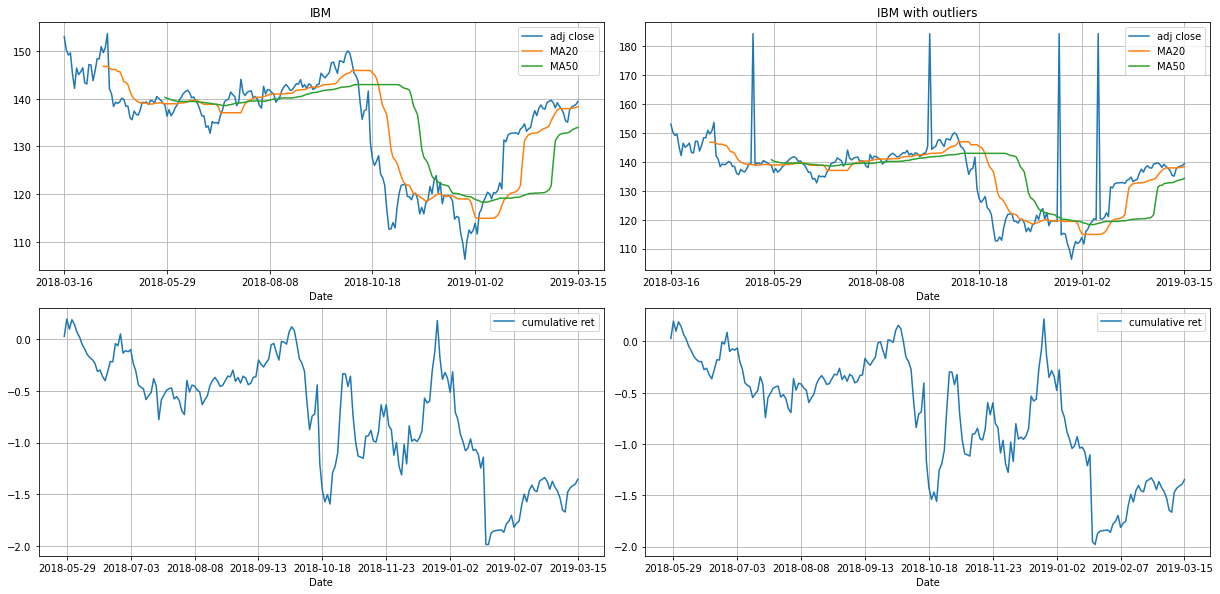

In [730]:
# Moving average crossover 
ibm_ma20 = adj_ibm.rolling(20).median()
ibm_ma50 = adj_ibm.rolling(50).median()

# with outliers
ibmout_ma20 = adjc_ibm.rolling(20).median()
ibmout_ma50 = adjc_ibm.rolling(50).median()

# Set up buy and sell rules
ibm_buysell0 = (ibm_ma20 - ibm_ma50).dropna()
ibm_buysell_out0 = (ibmout_ma20 - ibmout_ma50).dropna()

ibm_buysell = np.sign(ibm_buysell0)*10
ibm_buysell_out = np.sign(ibm_buysell_out0)*10

ibm_cum = np.cumsum(IBM['Returns']*ibm_buysell)
ibmout_cum = np.cumsum(IBM['Returns']*ibm_buysell_out)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# IBM
ax0 = axes[0,0]
adj_ibm.plot(ax=ax0, label='adj close')
ibm_ma20.plot(ax=ax0, label='MA20')
ibm_ma50.plot(ax=ax0, label='MA50')
ax0.set_title('IBM')
ax0.legend()
ax0.grid()

ax1 = axes[1,0]
ibm_cum.plot(ax=ax1, label='cumulative ret')
ax1.legend()
ax1.grid()

# with outliers
ax2 = axes[0,1]
adjc_ibm.plot(ax=ax2, label='adj close')
ibmout_ma20.plot(ax=ax2, label='MA20')
ibmout_ma50.plot(ax=ax2, label='MA50')
ax2.set_title('IBM with outliers')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
ibmout_cum.plot(ax=ax3, label='cumulative ret')
ax3.legend()
ax3.grid()

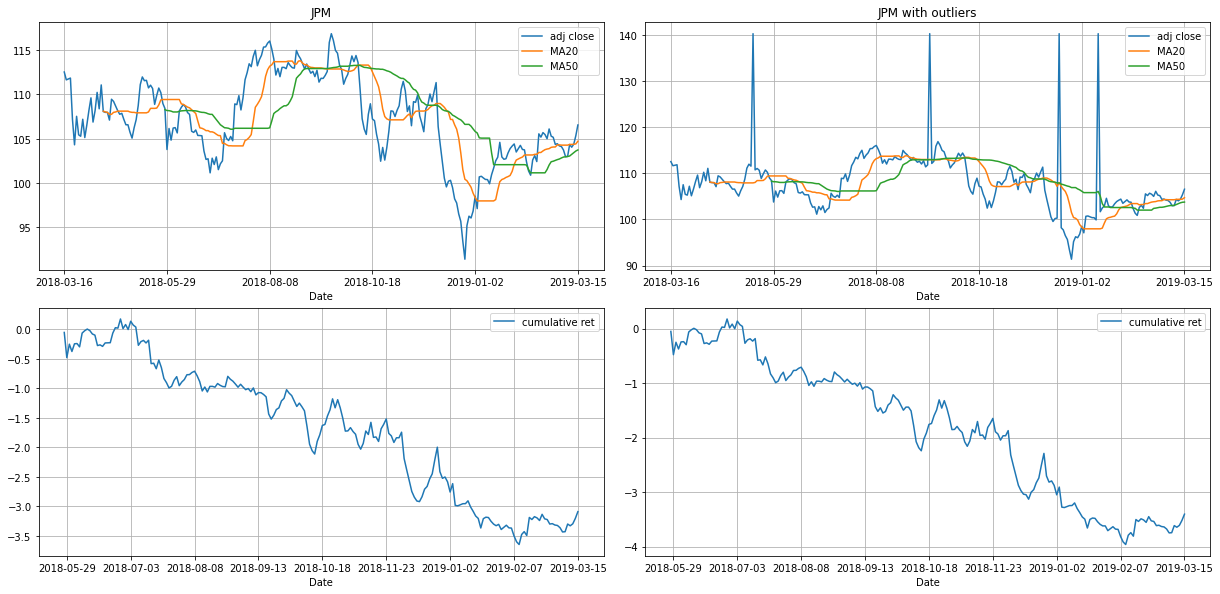

In [731]:
# Moving average crossover 
jpm_ma20 = adj_jpm.rolling(20).median()
jpm_ma50 = adj_jpm.rolling(50).median()

# with outliers
jpmout_ma20 = adjc_jpm.rolling(20).median()
jpmout_ma50 = adjc_jpm.rolling(50).median()

# Set up buy and sell rules
jpm_buysell0 = (jpm_ma20 - jpm_ma50).dropna()
jpm_buysell_out0 = (jpmout_ma20 - jpmout_ma50).dropna()

jpm_buysell = np.sign(jpm_buysell0)*10
jpm_buysell_out = np.sign(jpm_buysell_out0)*10

jpm_cum = np.cumsum(JPM['Returns']*jpm_buysell)
jpmout_cum = np.cumsum(JPM['Returns']*jpm_buysell_out)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# IBM
ax0 = axes[0,0]
adj_jpm.plot(ax=ax0, label='adj close')
jpm_ma20.plot(ax=ax0, label='MA20')
jpm_ma50.plot(ax=ax0, label='MA50')
ax0.set_title('JPM')
ax0.legend()
ax0.grid()

ax1 = axes[1,0]
jpm_cum.plot(ax=ax1, label='cumulative ret')
ax1.legend()
ax1.grid()

# with outliers
ax2 = axes[0,1]
adjc_jpm.plot(ax=ax2, label='adj close')
jpmout_ma20.plot(ax=ax2, label='MA20')
jpmout_ma50.plot(ax=ax2, label='MA50')
ax2.set_title('JPM with outliers')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
jpmout_cum.plot(ax=ax3, label='cumulative ret')
ax3.legend()
ax3.grid()

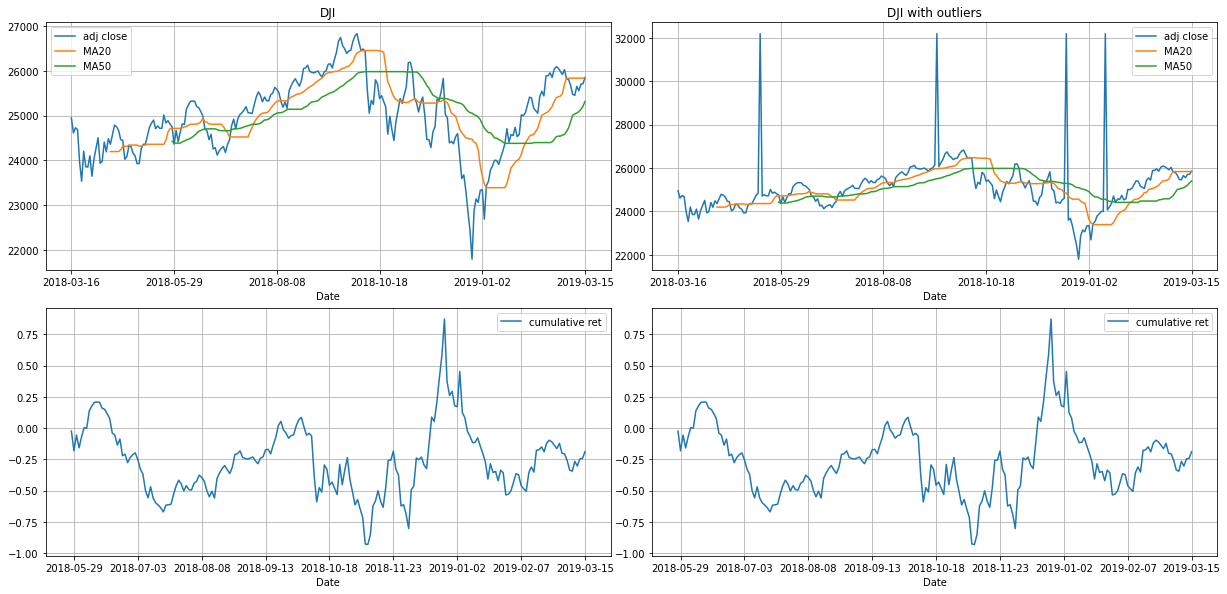

In [732]:
# Moving average crossover 
dji_ma20 = adj_dji.rolling(20).median()
dji_ma50 = adj_dji.rolling(50).median()

# with outliers
djiout_ma20 = adjc_dji.rolling(20).median()
djiout_ma50 = adjc_dji.rolling(50).median()

# Set up buy and sell rules
dji_buysell0 = (dji_ma20 - dji_ma50).dropna()
dji_buysell_out0 = (djiout_ma20 - djiout_ma50).dropna()

dji_buysell = np.sign(dji_buysell0)*10
dji_buysell_out = np.sign(dji_buysell_out0)*10

dji_cum = np.cumsum(DJI['Returns']*dji_buysell)
djiout_cum = np.cumsum(DJI['Returns']*dji_buysell_out)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,8))
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# DJI
ax0 = axes[0,0]
adj_dji.plot(ax=ax0, label='adj close')
dji_ma20.plot(ax=ax0, label='MA20')
dji_ma50.plot(ax=ax0, label='MA50')
ax0.set_title('DJI')
ax0.legend()
ax0.grid()

ax1 = axes[1,0]
dji_cum.plot(ax=ax1, label='cumulative ret')
ax1.legend()
ax1.grid()

# with outliers
ax2 = axes[0,1]
adjc_dji.plot(ax=ax2, label='adj close')
djiout_ma20.plot(ax=ax2, label='MA20')
djiout_ma50.plot(ax=ax2, label='MA50')
ax2.set_title('DJI with outliers')
ax2.legend()
ax2.grid()

ax3 = axes[1,1]
djiout_cum.plot(ax=ax3, label='cumulative ret')
ax3.legend()
ax3.grid()

# 5 Graphs in Finance

## 5.1  Assets selection

In [ ]:
# Load data
df = pd.read_csv('snp_allstocks_2015_2019.csv', header=0, index_col=0)
info = pd.read_csv('snp_info.csv', index_col=0)

In [745]:
# Grab the sector info
health = info[info['GICS Sub Industry']=='Health Care Equipment']
#health

# Pick the ten assets from health care equipment industry
assets_list = ['HOLX','ABMD','A','EW','BSX','ISRG','JNJ','RMD','SYK','ZBH']

In [829]:
assets = df[assets_list].fillna(value=0, method=None)
logret = (np.log(assets)).diff(1)

Text(0, 0.5, 'Log returns')

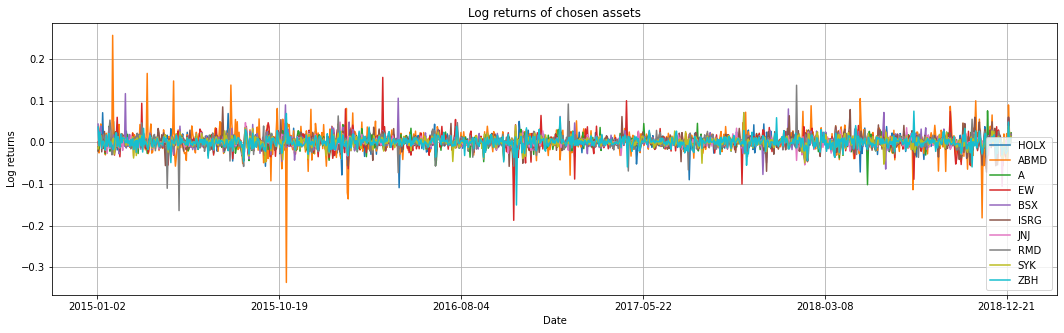

In [830]:
logret.plot(grid=True, title='Log returns of chosen assets', figsize=(18,5), legend=True).set_ylabel('Log returns')

In [751]:
# Show the list of chosen assets
df_info = info.copy().set_index('Symbol')
df_info.loc[assets_list]

Security SEC filings  GICS Sector  \
Symbol                                                      
HOLX                     Hologic     reports  Health Care   
ABMD                 ABIOMED Inc     reports  Health Care   
A       Agilent Technologies Inc     reports  Health Care   
EW          Edwards Lifesciences     reports  Health Care   
BSX            Boston Scientific     reports  Health Care   
ISRG     Intuitive Surgical Inc.     reports  Health Care   
JNJ            Johnson & Johnson     reports  Health Care   
RMD                       ResMed     reports  Health Care   
SYK                Stryker Corp.     reports  Health Care   
ZBH       Zimmer Biomet Holdings     reports  Health Care   

            GICS Sub Industry          Headquarters Location  \
Symbol                                                         
HOLX    Health Care Equipment     Marlborough, Massachusetts   
ABMD    Health Care Equipment         Danvers, Massachusetts   
A       Health Care Equipment        Santa Clara, California   
EW      Health Care Equipment             Irvine, California   
BSX     Health Care Equipment  Marlborough, Massachusetts[6]   
ISRG    Health Care Equipment          Sunnyvale, California   
JNJ     Health Care Equipment      New Brunswick, New Jersey   
RMD     Health Care Equipment          San Diego, California   
SYK     Health Care Equipment            Kalamazoo, Michigan   
ZBH     Health Care Equipment                Warsaw, Indiana   

       Date first added[3][4]      CIK Founded  
Symbol                                          
HOLX               2016-03-30   859737     NaN  
ABMD               2018-05-31   815094    1981  
A                  2000-06-05  1090872    1999  
EW                 2011-04-01  1099800     NaN  
BSX                1995-02-24   885725     NaN  
ISRG               2008-06-02  1035267     NaN  
JNJ                1973-06-30   200406    1886  
RMD                2017-07-26   943819     NaN  
SYK                2000-12-12   310764     NaN  
ZBH                2001-08-07  1136869     NaN

## 5.2 Assets correlation matrix

In [855]:
import networkx as nx

corr = logret.corr()
corr

HOLX      ABMD         A        EW       BSX      ISRG       JNJ  \
HOLX  1.000000  0.338087  0.470574  0.412860  0.439185  0.418019  0.361680   
ABMD  0.338087  1.000000  0.319138  0.374798  0.352397  0.387829  0.185497   
A     0.470574  0.319138  1.000000  0.440496  0.527351  0.535819  0.445167   
EW    0.412860  0.374798  0.440496  1.000000  0.446480  0.479470  0.323487   
BSX   0.439185  0.352397  0.527351  0.446480  1.000000  0.503569  0.385653   
ISRG  0.418019  0.387829  0.535819  0.479470  0.503569  1.000000  0.319450   
JNJ   0.361680  0.185497  0.445167  0.323487  0.385653  0.319450  1.000000   
RMD   0.307176  0.291500  0.380689  0.376604  0.341430  0.387901  0.238408   
SYK   0.472921  0.348037  0.506825  0.464573  0.506418  0.509046  0.548555   
ZBH   0.430003  0.222245  0.464917  0.383769  0.476562  0.415585  0.410563   

           RMD       SYK       ZBH  
HOLX  0.307176  0.472921  0.430003  
ABMD  0.291500  0.348037  0.222245  
A     0.380689  0.506825  0.464917  
EW    0.376604  0.464573  0.383769  
BSX   0.341430  0.506418  0.476562  
ISRG  0.387901  0.509046  0.415585  
JNJ   0.238408  0.548555  0.410563  
RMD   1.000000  0.423899  0.334344  
SYK   0.423899  1.000000  0.542913  
ZBH   0.334344  0.542913  1.000000

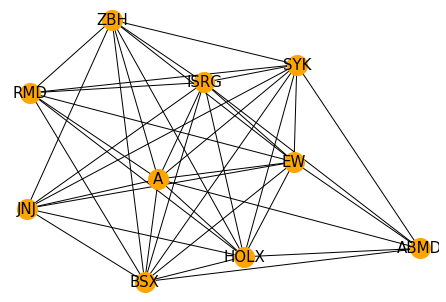

In [835]:
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[abs(links['value'] > 0.3) & (links['var1'] != links['var2'])]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

Lines between the nodes are drawn when the correlation of two assets is greater than 0.4. The plot shows how strong the connection is within the industry. When the threshold is changed to 0.3 (where the plot will show all the connections between stocks if the correlation is larger than 0.3), more connections will show up. When the correlation threshold is increased to 0.5, only 6 stocks show up. Therefore, it might be concluded that there is a relatively weak correlation within the health care equipment industry.

## 5.3 Re-ordering the assets

In [880]:
# generate random sample row for the assets
corr_vert = logret.sample(frac=1,axis='index').corr()
corr_vert

HOLX      ABMD         A        EW       BSX      ISRG       JNJ  \
HOLX  1.000000  0.338087  0.470574  0.412860  0.439185  0.418019  0.361680   
ABMD  0.338087  1.000000  0.319138  0.374798  0.352397  0.387829  0.185497   
A     0.470574  0.319138  1.000000  0.440496  0.527351  0.535819  0.445167   
EW    0.412860  0.374798  0.440496  1.000000  0.446480  0.479470  0.323487   
BSX   0.439185  0.352397  0.527351  0.446480  1.000000  0.503569  0.385653   
ISRG  0.418019  0.387829  0.535819  0.479470  0.503569  1.000000  0.319450   
JNJ   0.361680  0.185497  0.445167  0.323487  0.385653  0.319450  1.000000   
RMD   0.307176  0.291500  0.380689  0.376604  0.341430  0.387901  0.238408   
SYK   0.472921  0.348037  0.506825  0.464573  0.506418  0.509046  0.548555   
ZBH   0.430003  0.222245  0.464917  0.383769  0.476562  0.415585  0.410563   

           RMD       SYK       ZBH  
HOLX  0.307176  0.472921  0.430003  
ABMD  0.291500  0.348037  0.222245  
A     0.380689  0.506825  0.464917  
EW    0.376604  0.464573  0.383769  
BSX   0.341430  0.506418  0.476562  
ISRG  0.387901  0.509046  0.415585  
JNJ   0.238408  0.548555  0.410563  
RMD   1.000000  0.423899  0.334344  
SYK   0.423899  1.000000  0.542913  
ZBH   0.334344  0.542913  1.000000

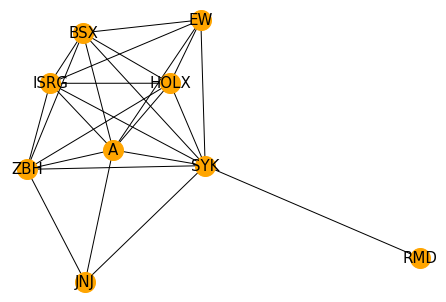

In [886]:
# Transform it in a links data frame (3 columns only):
links = corr_vert.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[abs(links['value'] > 0.4) & (links['var1'] != links['var2'])]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

In [883]:
# reverse the log returns to re-order by time
rev = logret.iloc[::-1]
corr_rev = rev.corr()

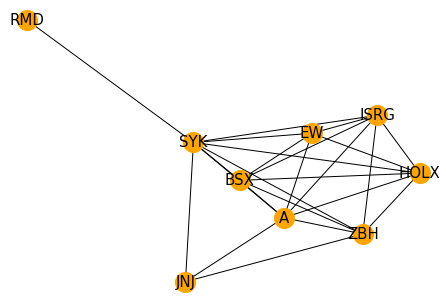

In [884]:
# Transform it in a links data frame (3 columns only):
links = corr_rev.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[abs(links['value'] > 0.4) & (links['var1'] != links['var2'])]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

## 5.4 Spectral distance matrix

In [842]:
logri = np.log(assets).diff(1).dropna()
spec_d = pd.DataFrame(index=logri.index, columns=logri.columns)

for ticker in logri.columns:
    spec_d[ticker]=np.abs(np.fft.fft(logri[ticker]))**2 

In [844]:
spec_d_corr = spec_d.corr()

In [845]:
spec_d.corr()

HOLX      ABMD         A        EW       BSX      ISRG       JNJ  \
HOLX  1.000000  0.124604  0.170532  0.191065  0.171455  0.177556  0.120535   
ABMD  0.124604  1.000000  0.110070  0.224741  0.041931  0.166171 -0.020839   
A     0.170532  0.110070  1.000000  0.181006  0.253141  0.208078  0.126227   
EW    0.191065  0.224741  0.181006  1.000000  0.197461  0.147915  0.064513   
BSX   0.171455  0.041931  0.253141  0.197461  1.000000  0.257153  0.128429   
ISRG  0.177556  0.166171  0.208078  0.147915  0.257153  1.000000  0.097053   
JNJ   0.120535 -0.020839  0.126227  0.064513  0.128429  0.097053  1.000000   
RMD   0.210020  0.099999  0.165421  0.045469  0.104052  0.193318  0.097950   
SYK   0.187755  0.101661  0.262526  0.163962  0.296718  0.220313  0.249685   
ZBH   0.163848  0.018006  0.135740  0.101878  0.187871  0.183894  0.101832   

           RMD       SYK       ZBH  
HOLX  0.210020  0.187755  0.163848  
ABMD  0.099999  0.101661  0.018006  
A     0.165421  0.262526  0.135740  
EW    0.045469  0.163962  0.101878  
BSX   0.104052  0.296718  0.187871  
ISRG  0.193318  0.220313  0.183894  
JNJ   0.097950  0.249685  0.101832  
RMD   1.000000  0.174116  0.071335  
SYK   0.174116  1.000000  0.213473  
ZBH   0.071335  0.213473  1.000000

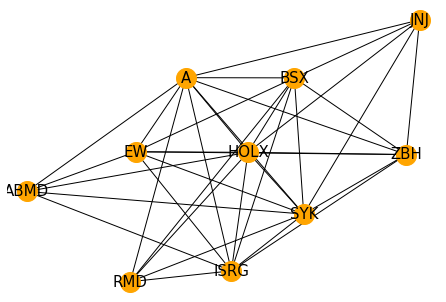

In [848]:
# Transform it in a links data frame (3 columns only):
links = spec_d_corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[abs(links['value'] > 0.1) & (links['var1'] != links['var2'])]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

In [851]:
# generate random sample row for the assets
ram = logri.sample(frac=1,axis='index')
ramspec_d = pd.DataFrame(index=logri.index, columns=logri.columns)
for ticker in logri.columns:
    ramspec_d[ticker]=np.abs(np.fft.fft(ram[ticker]))**2 
corr_ramspec = ramspec_d.corr()
corr_ramspec

HOLX      ABMD         A        EW       BSX      ISRG       JNJ  \
HOLX  1.000000  0.181847  0.221715  0.206279  0.149115  0.169284  0.065733   
ABMD  0.181847  1.000000  0.178827  0.167121  0.095919  0.245367 -0.031549   
A     0.221715  0.178827  1.000000  0.233511  0.198769  0.302492  0.167529   
EW    0.206279  0.167121  0.233511  1.000000  0.118379  0.198917  0.034491   
BSX   0.149115  0.095919  0.198769  0.118379  1.000000  0.225500  0.135351   
ISRG  0.169284  0.245367  0.302492  0.198917  0.225500  1.000000  0.103291   
JNJ   0.065733 -0.031549  0.167529  0.034491  0.135351  0.103291  1.000000   
RMD   0.147045  0.142677  0.189817  0.219951  0.020260  0.243527  0.009941   
SYK   0.164544  0.096028  0.181500  0.218040  0.177314  0.266924  0.251415   
ZBH   0.099475  0.033060  0.155917  0.126511  0.100096  0.227992  0.146090   

           RMD       SYK       ZBH  
HOLX  0.147045  0.164544  0.099475  
ABMD  0.142677  0.096028  0.033060  
A     0.189817  0.181500  0.155917  
EW    0.219951  0.218040  0.126511  
BSX   0.020260  0.177314  0.100096  
ISRG  0.243527  0.266924  0.227992  
JNJ   0.009941  0.251415  0.146090  
RMD   1.000000  0.130458  0.069618  
SYK   0.130458  1.000000  0.246966  
ZBH   0.069618  0.246966  1.000000

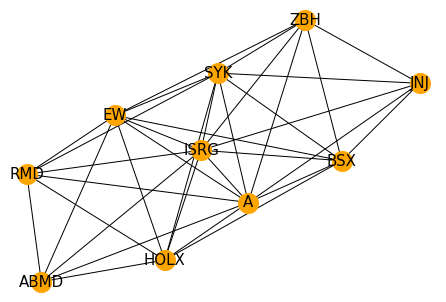

In [852]:
# Transform it in a links data frame (3 columns only):
links = corr_ramspec.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[abs(links['value'] > 0.1) & (links['var1'] != links['var2'])]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

In [853]:
# reverse the log returns to re-order by time
revs = logri.iloc[::-1]
revspec_d = pd.DataFrame(index=logri.index, columns=logri.columns)
for ticker in logri.columns:
    revspec_d[ticker]=np.abs(np.fft.fft(revs[ticker]))**2 
corr_revspec = revspec_d.corr()
corr_revspec

HOLX      ABMD         A        EW       BSX      ISRG       JNJ  \
HOLX  1.000000  0.124604  0.170532  0.191065  0.171455  0.177556  0.120535   
ABMD  0.124604  1.000000  0.110070  0.224741  0.041931  0.166171 -0.020839   
A     0.170532  0.110070  1.000000  0.181006  0.253141  0.208078  0.126227   
EW    0.191065  0.224741  0.181006  1.000000  0.197461  0.147915  0.064513   
BSX   0.171455  0.041931  0.253141  0.197461  1.000000  0.257153  0.128429   
ISRG  0.177556  0.166171  0.208078  0.147915  0.257153  1.000000  0.097053   
JNJ   0.120535 -0.020839  0.126227  0.064513  0.128429  0.097053  1.000000   
RMD   0.210020  0.099999  0.165421  0.045469  0.104052  0.193318  0.097950   
SYK   0.187755  0.101661  0.262526  0.163962  0.296718  0.220313  0.249685   
ZBH   0.163848  0.018006  0.135740  0.101878  0.187871  0.183894  0.101832   

           RMD       SYK       ZBH  
HOLX  0.210020  0.187755  0.163848  
ABMD  0.099999  0.101661  0.018006  
A     0.165421  0.262526  0.135740  
EW    0.045469  0.163962  0.101878  
BSX   0.104052  0.296718  0.187871  
ISRG  0.193318  0.220313  0.183894  
JNJ   0.097950  0.249685  0.101832  
RMD   1.000000  0.174116  0.071335  
SYK   0.174116  1.000000  0.213473  
ZBH   0.071335  0.213473  1.000000

## 5.5 Raw price analysis

In [863]:
rawret = assets.fillna(value=0, method=None)
corr_ret = rawret.corr()

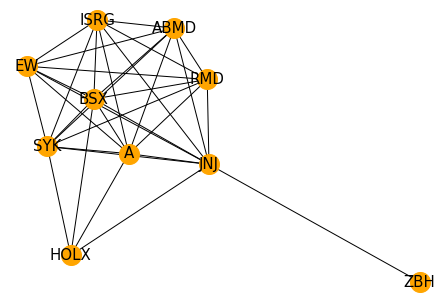

In [864]:
# Transform it in a links data frame (3 columns only):
links = corr_ret.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[abs(links['value'] > 0.5) & (links['var1'] != links['var2'])]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

In [856]:
ret_spec = pd.DataFrame(index=rawret.index, columns=rawret.columns)

for ticker in rawret.columns:
    ret_spec[ticker]=np.abs(np.fft.fft(rawret[ticker]))**2 

In [860]:
corr_retspec = ret_spec.corr()
corr_retspec

HOLX      ABMD         A        EW       BSX      ISRG       JNJ  \
HOLX  1.000000  0.983452  0.999563  0.999724  0.999726  0.996240  0.999982   
ABMD  0.983452  1.000000  0.987868  0.987318  0.987359  0.995080  0.984415   
A     0.999563  0.987868  1.000000  0.999852  0.999945  0.998301  0.999721   
EW    0.999724  0.987318  0.999852  1.000000  0.999963  0.997829  0.999822   
BSX   0.999726  0.987359  0.999945  0.999963  1.000000  0.997979  0.999840   
ISRG  0.996240  0.995080  0.998301  0.997829  0.997979  1.000000  0.996725   
JNJ   0.999982  0.984415  0.999721  0.999822  0.999840  0.996725  1.000000   
RMD   0.999556  0.988209  0.999985  0.999912  0.999964  0.998367  0.999713   
SYK   0.999720  0.987246  0.999977  0.999932  0.999986  0.997999  0.999842   
ZBH   0.999999  0.983369  0.999544  0.999718  0.999712  0.996191  0.999978   

           RMD       SYK       ZBH  
HOLX  0.999556  0.999720  0.999999  
ABMD  0.988209  0.987246  0.983369  
A     0.999985  0.999977  0.999544  
EW    0.999912  0.999932  0.999718  
BSX   0.999964  0.999986  0.999712  
ISRG  0.998367  0.997999  0.996191  
JNJ   0.999713  0.999842  0.999978  
RMD   1.000000  0.999979  0.999540  
SYK   0.999979  1.000000  0.999706  
ZBH   0.999540  0.999706  1.000000

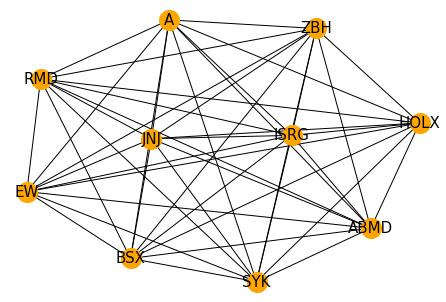

In [862]:
# Transform it in a links data frame (3 columns only):
links = corr_retspec.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[abs(links['value'] > 0.4) & (links['var1'] != links['var2'])]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)